### 0. Imports

In [41]:
%load_ext autoreload
%autoreload 2

# Data transformation
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np


# Visualizations
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Progress loops
# -----------------------------------------------------------------------
from tqdm import tqdm

# Handle warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")

# modify system variables
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # append parent folder to path

# modify operating system structures
# -----------------------------------------------------------------------
import os

# import support functions
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_clustering as sc
import src.data_visualization_support as dvs


# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr
from scipy.stats.mstats import winsorize
from scipy.stats import trim_mean

# work with serialized pickle files
# -----------------------------------------------------------------------
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Intro to EDA notebook and data import

## 1.1 Introduction

The purporse of this EDA notebook is to further explore data at its most granular level to understand it more deeply, as we could yet extract some value from it before aggregation to the desired levels. This EDA will additionally allow to find insights hidden in the data that could:
- Bring business value 
- Inform some transformations or configuration for the upcoming machine learning models
- Shed light into data quality problems

A business goal has not yet been decided and therefore this phase is more useful than ever to discover what are the most profitable patterns to chase in order to improve the business.

## 1.2 Data import

In [42]:
global_superstore = pd.read_pickle("../data/cleaned/global_superstore.pkl")

# 2. EDA

## 2.1 Univariate data analysis - row level

In [43]:
visualizador = sp.Visualizador(global_superstore.drop(columns=["row_id","order_id","order_date","ship_date","customer_id","customer_name","product_name","product_id"]))

### 2.1.1 Numerical features

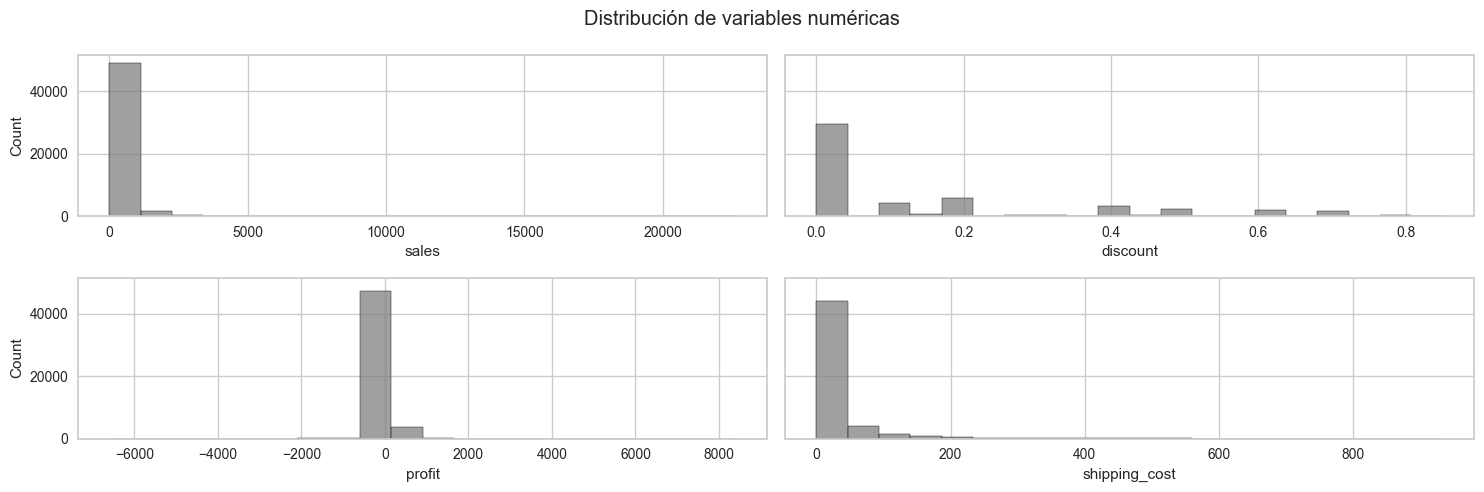

In [44]:
visualizador.plot_numericas()

Sales, profit and shipping costs all have heavily skewed values. These outliers will have to be treated during preprocessing for both clustering and regression models, especially for the formers.

Discounts are mostly low, although there are some very high discounts, presumably for excellent customers or for very special promotions in certain products.

Although sales and shipping costs are always positive, profits are skewed on both ends, with a large amount of profits being negative. Let us observe those values in particular, trimming both ends by 1%:

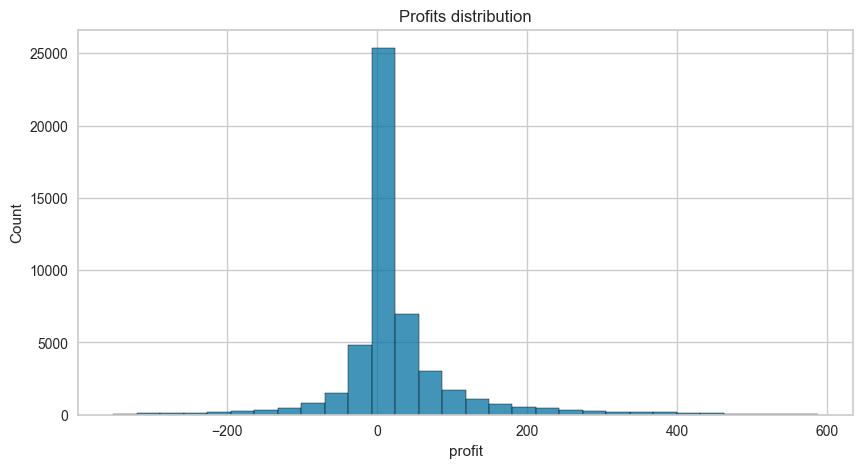

count       mean         std       min  25%   50%    75%       max
profit  51290.0  28.610982  174.340972 -6599.978  0.0  9.24  36.81  8399.976

In [45]:
lower_bound = np.percentile(global_superstore['profit'], 1)  # 1st percentile
upper_bound = np.percentile(global_superstore['profit'], 99)  # 99th percentile


plt.figure(figsize=(10,5))
plt.title("Profits distribution")
sns.histplot(data=global_superstore[global_superstore["profit"].between(lower_bound,upper_bound)],
             x="profit", bins=30)
plt.show()

global_superstore[["profit"]].describe().T

This means that a lot of products bring negative profits on their own. Does the same happen for orders?

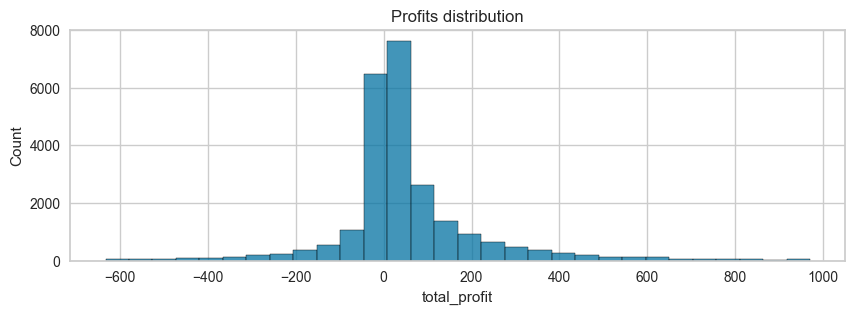

count       mean         std        min  25%    50%      75%  \
total_profit  25035.0  58.616229  275.302973 -6892.3748  0.0  20.07  89.1737   

                    max  
total_profit  8762.3891

In [46]:
orders_profit = global_superstore.groupby(["order_id"]).agg(total_profit=("profit","sum"))

# clip chart by 1 and 99 percentiles
lower_bound = np.percentile(orders_profit['total_profit'], 1)  # 1st percentile
upper_bound = np.percentile(orders_profit['total_profit'], 99)  # 99th percentile

# plot chart
plt.figure(figsize=(10,3))
plt.title("Profits distribution")
sns.histplot(data=orders_profit[orders_profit["total_profit"].between(lower_bound,upper_bound)],
             x="total_profit", bins=30)
plt.show()

orders_profit.describe().T

For orders, the range gets wider, but the mean and median profits increase. Which means that not all orders are profitable, but at least the loss from individual products gets somehow compensated.

### 2.1.2 Categorical features

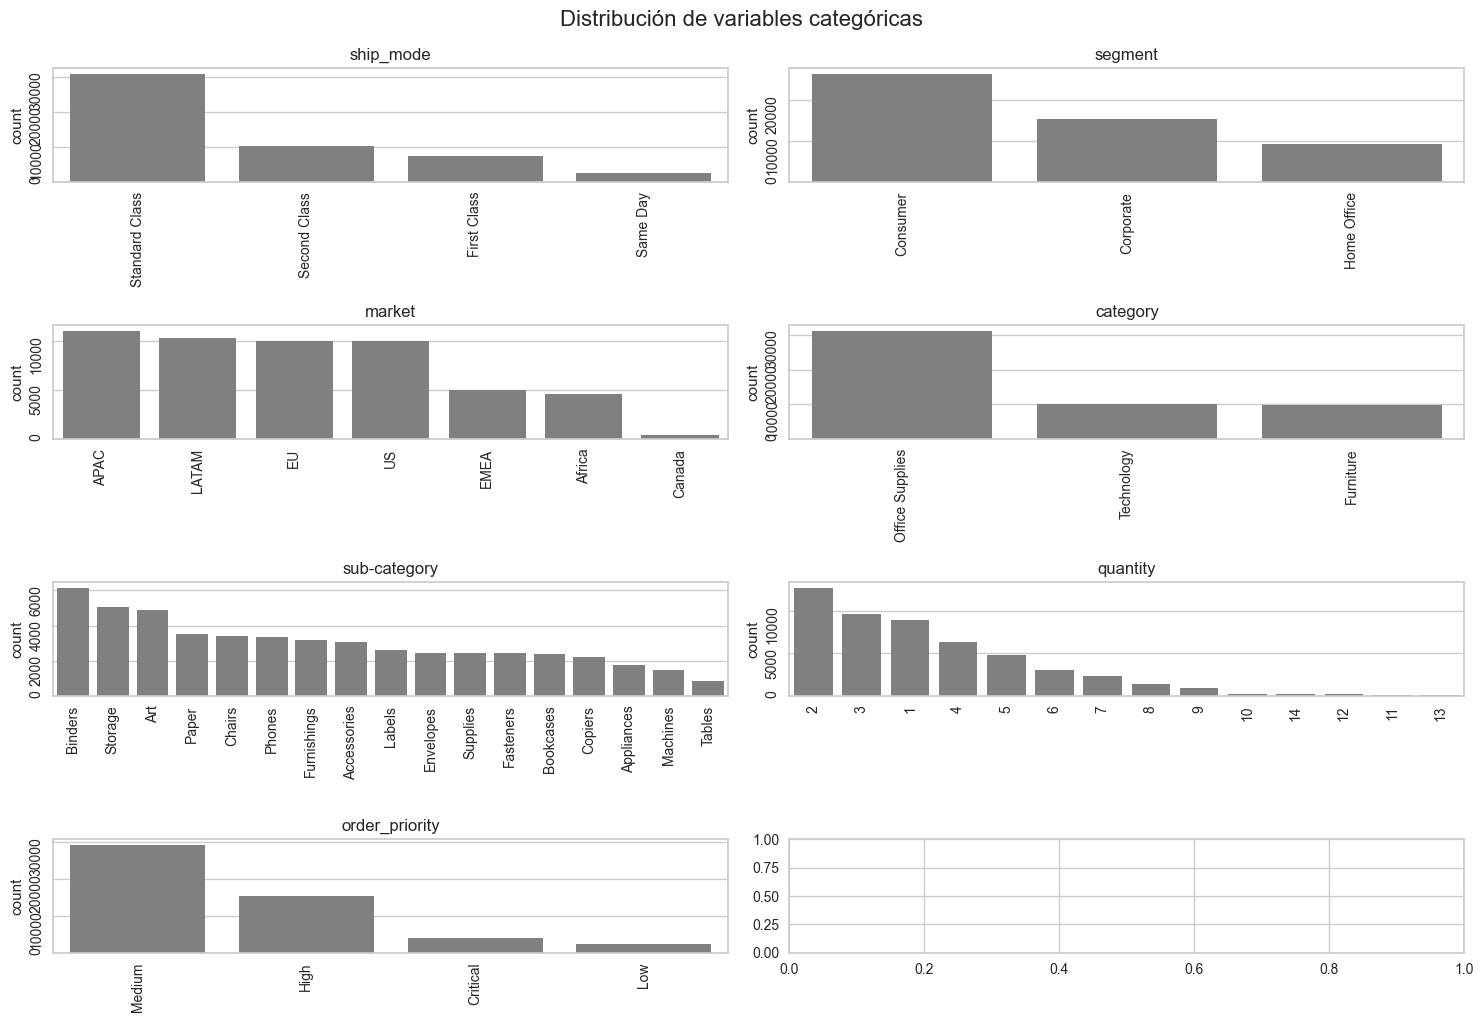

In [47]:
visualizador.plot_categoricas(tamano_grafica=(15,10))

**Ship_mode** 

Seems to follow a logical order in its frequency, which is ideal for its encoding into frequency. Category representations are within healty ranges.

**Segment** 

Gives indication that about half of products are bought for consumers, while the remaining are bought for professional use.

**Market** 

Follows a uniform distribution. However, there is a mistake with the categories EU and Africa, as they really are part of EMEA. 

There is no way to tell whether EU is not included to make it a distinction, or the same goes for Africa. It could be that after a certain time there is a change in typology, however we see below that its not the case. We leave it as is to see if they should be grouped or not. Canada gets grouped inside US due to its low relative representation.

In [48]:
# group Canada inside US
global_superstore["market"] = np.where(global_superstore["market"]=="Canada","US",global_superstore["market"])

# show EU, EMEA and Africa time ranges
(global_superstore.groupby("market")[["order_date"]].agg(["min","max"]).T)[["EU","EMEA","Africa"]]

market                 EU       EMEA     Africa
order_date min 2011-01-01 2011-01-01 2011-01-01
           max 2014-12-31 2014-12-31 2014-12-31

**Category** of products are dominated mostly by Office Supplies.

**Subcategory** starts to show a fairly high cardinality. It is ncessary to check its value counts.

In [49]:
global_superstore[["sub-category"]].value_counts().reset_index().assign(pct=lambda row: row["count"]/global_superstore.shape[0]*100)

sub-category  count        pct
0       Binders   6152  11.994541
1       Storage   5059   9.863521
2           Art   4883   9.520374
3         Paper   3538   6.898031
4        Chairs   3434   6.695262
5        Phones   3357   6.545136
6   Furnishings   3170   6.180542
7   Accessories   3075   5.995321
8        Labels   2606   5.080912
9     Envelopes   2435   4.747514
10     Supplies   2425   4.728017
11    Fasteners   2420   4.718269
12    Bookcases   2411   4.700721
13      Copiers   2223   4.334178
14   Appliances   1755   3.421720
15     Machines   1486   2.897251
16       Tables    861   1.678690

It looks like the least frequent, tables, has enough representation. However, if the data divided, it should be rechecked.

**quantity** should be grouped for quanitities beyond 9 products if kept as a category. However, although it has little number of unique values, these will grow as they get aggregated. For now, converting back to number:

In [50]:
global_superstore["quantity"] = global_superstore["quantity"].astype(int)
# global_superstore["quantity"] = np.where(global_superstore["quantity"] >=9, "9 or more",global_superstore["quantity"])

**order priority** has good representation. Their categories follow a logical frequency distribution except for low priorities.

## 2.2 Multivariate analysis

Analysis of how features interact with each other at row level (no aggregation) and different levels of aggregation

### 2.2.1 Numerical features vs. numerical features - Row level

Interaction between features at the row level information available without aggregation.

**Q:** Does price decrease or discount increase with quantity from a general point of view?

<Axes: >

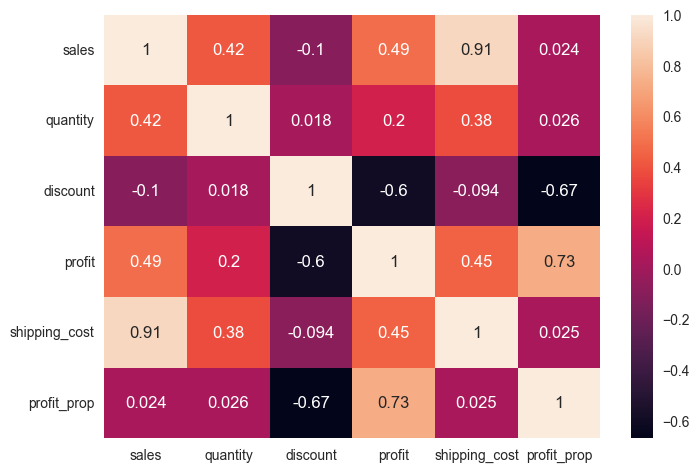

In [51]:
# create profit % feature to add into analysis
global_superstore["profit_prop"] = global_superstore["profit"] / global_superstore["sales"]


# check correlations
sns.heatmap(global_superstore.corr(numeric_only=True, method="spearman"),annot=True)

From this matrix, there are obvious positive correlations:
- Profit and sales
- Sales and quantity
- Profit margin (profit_prop) with respect to sales, quantity, etc

But there are 2 interesting correlations:
1. Shipping cost and sales: Shipping costs are related to how expensive the whole set of bought items is.
2. Sales has a slighly negative correlation with discount, which suggests that discounts have already been applied.

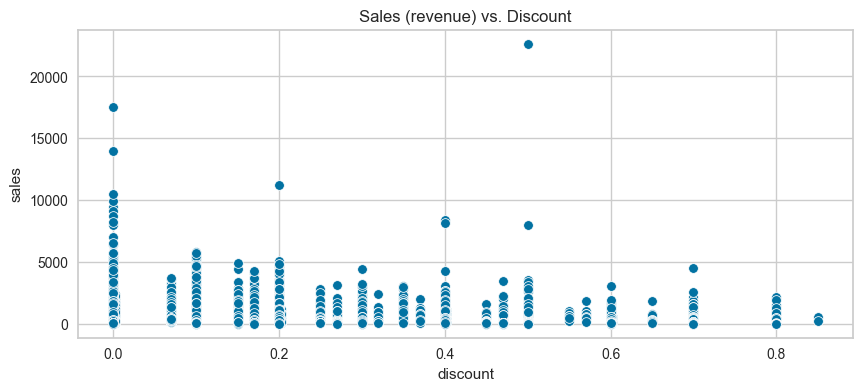

In [52]:
plt.figure(figsize=(10,4))
plt.title("Sales (revenue) vs. Discount")
sns.scatterplot(data=global_superstore,
                y="sales",
                x="discount")

plt.show()

Seeing this, the most correct way to calculate discounted prices to later aggregate them in a way that allows to calculate discount % is the following:

In [53]:
# create discounted price columns
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]

# create original cost column
global_superstore["original_price"] = global_superstore["discounted_price"] + global_superstore["sales"]

Shipping costs are very correlated with sales, and they are also correlated with discounts in almost an exact same pearson correlation and shape:

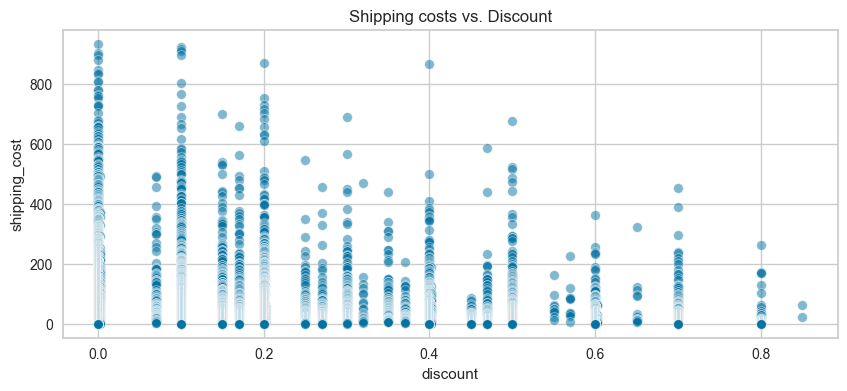

In [54]:
plt.figure(figsize=(10,4))
plt.title("Shipping costs vs. Discount")
sns.scatterplot(data=global_superstore,
                y="shipping_cost",
                x="discount", alpha=0.5)

plt.show()

This points to the fact that shipping costs could be discounted by discounts too. Let us quickly inspect all numerical relationships via pairplot:

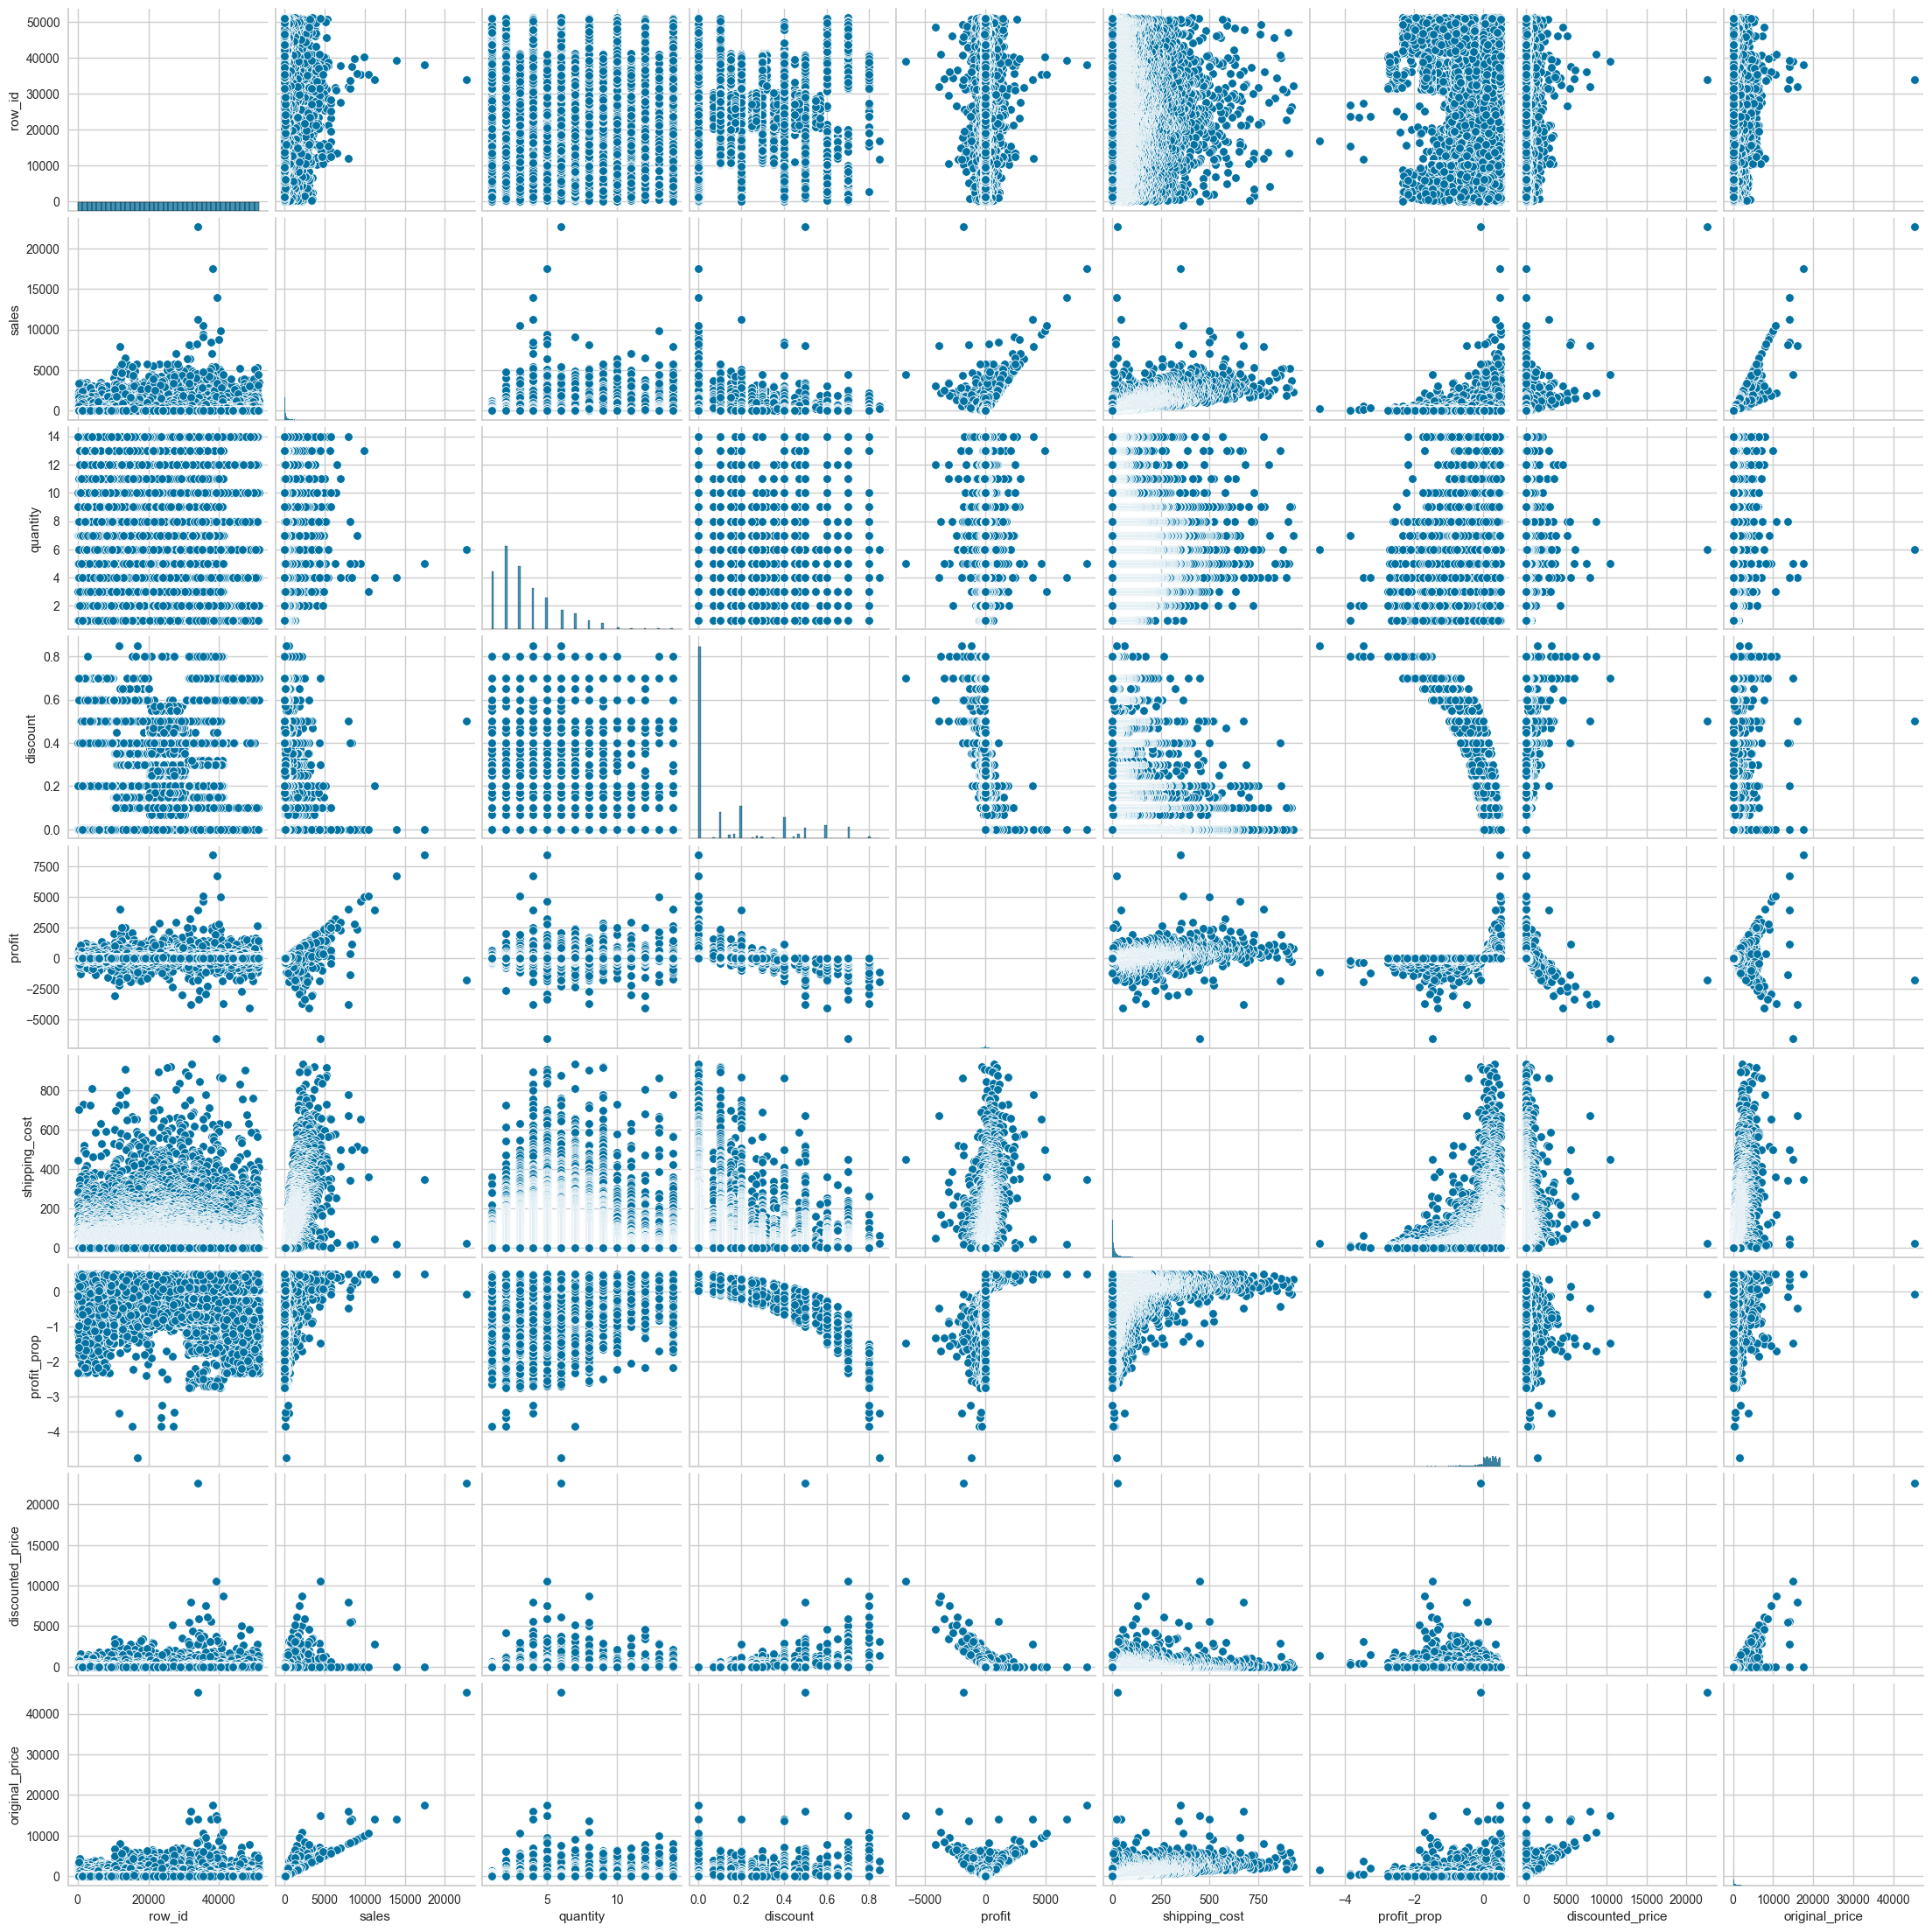

In [55]:
sns.pairplot(global_superstore)

Above, the negative correlation between discounts and profits is identified. Zoomin in into it:

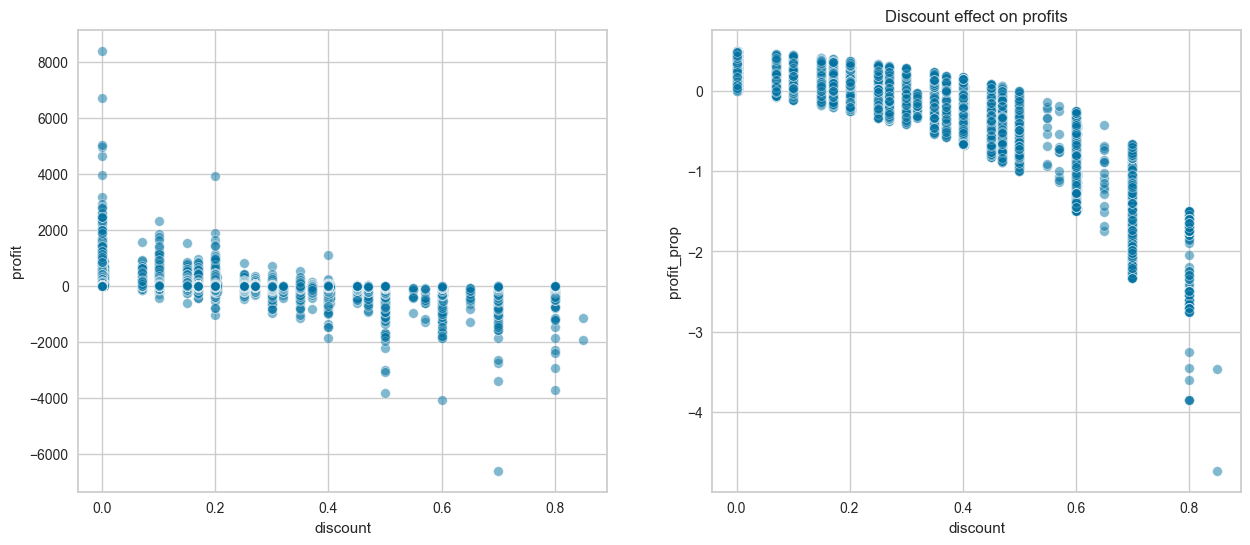

In [58]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

plt.title("Discount effect on profits")
sns.scatterplot(data=global_superstore,
                y="profit",
                x="discount", alpha=0.5, ax=axes[0])

sns.scatterplot(data=global_superstore,
                y="profit_prop",
                x="discount", alpha=0.5, ax=axes[1])

plt.show()

Excessive discounts eat away the profit margins obtained from products. They can be assumed to a certain level, but beyond 40-50% they always result in losses. Therefore, an important insight has been obtained, which should be acted upon by uncovering why such high discounts are given; is this a recurring pattern due to seasonal offers? is this to get rid of excessive stock? is this performed to attract certain customers?

It is now interesting to calculate the original price per unit:

In [59]:
global_superstore["original_ppu"] = (global_superstore["sales"] + global_superstore["discounted_price"]) / global_superstore["quantity"]

Checking wether this calculation is correct with products that have both > 0% discount and 0 discount:

In [60]:
global_superstore.loc[global_superstore["product_name"].str.startswith("#10 Gummed Flap White Envelopes, 100/Box"),["quantity","sales","discount","original_price","original_ppu"]]

quantity   sales  discount  original_price  original_ppu
48240         2   8.260       0.0            8.26          4.13
48248         4  16.520       0.0           16.52          4.13
48586         3   9.912       0.2           12.39          4.13
51189         2   6.608       0.2            8.26          4.13

On the first and last row above, we see that the original price calculated is correct.

**Q**: What is the impact of discounts in total profit?

In [80]:
# differentiate positive and negative profits
global_superstore["neg_profit"] = np.where(global_superstore["profit"] < 0, global_superstore["profit"], 0)
global_superstore["pos_profit"] = np.where(global_superstore["profit"] > 0, global_superstore["profit"], 0)

# put together for plotting and melt
yearly_profits = global_superstore.set_index("order_date")[["pos_profit", "neg_profit"]].resample("YE").sum().reset_index()
yearly_profits["neg_profit"] = np.abs(yearly_profits["neg_profit"])

melted_profits = yearly_profits.melt(id_vars="order_date", var_name="Profit_Type", value_name="Profit")

Plot the impact of negative profits (losses) due to discounts:

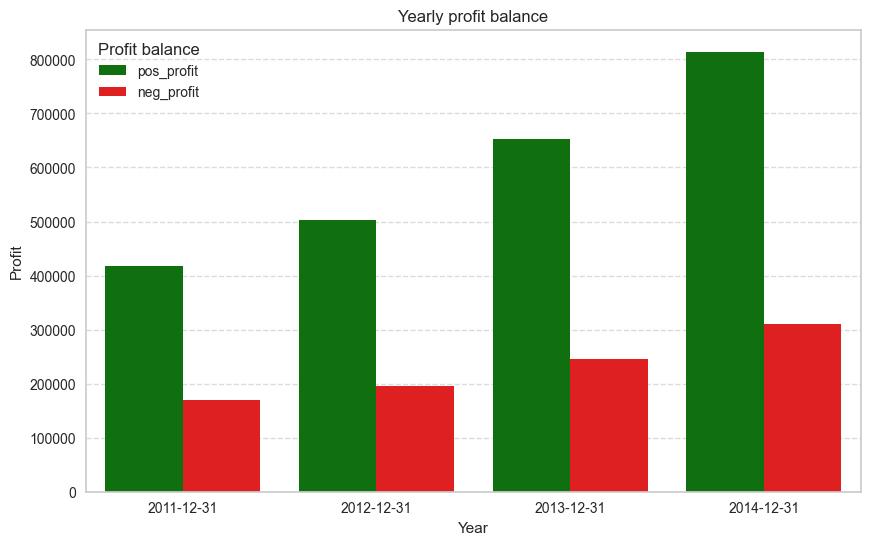

In [82]:
# set a color palette
palette = {"pos_profit": "green", "neg_profit": "red"}

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Yearly profit balance")
sns.barplot(
    data=melted_profits,
    x="order_date",
    y="Profit",
    hue="Profit_Type",
    palette=palette,
    ax=ax
)

plt.xlabel("Year")
plt.ylabel("Profit")
plt.legend(title="Profit balance", loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


**Q:** Are discounts designed for small purchases to attract bigger revenue purchases?

No. Yearly revenue from sales over 5000 is marginal compared to that of small revenue:

In [87]:
yearly_profits_under_5000 = global_superstore[global_superstore["sales"]<5000].set_index("order_date")[["sales","profit"]].resample("YE").sum()
yearly_profits_over_5000 = global_superstore[global_superstore["sales"]>5000].set_index("order_date")[["sales","profit"]].resample("YE").sum()

print("Small 'sales' purchases revenue and profit:")
display(yearly_profits_under_5000)

print("\nBig 'sales' purchases revenue and profit:")
yearly_profits_over_5000

Small 'sales' purchases revenue and profit:


sales        profit
order_date                            
2011-12-31  2.174397e+06  234708.28524
2012-12-31  2.637381e+06  299417.56010
2013-12-31  3.307675e+06  374167.74378
2014-12-31  4.200034e+06  473707.25346


Big 'sales' purchases revenue and profit:


sales      profit
order_date                       
2011-12-31  85054.050  14232.5263
2012-12-31  40058.114   7997.7190
2013-12-31  98071.247  32767.4864
2014-12-31  99831.584  30458.7170

**Q**: Is there a correlation with ship mode and shipping cost?

Yes. It seems that shipping cost determines the ship_mode, which in turn shipping cost is determined according to the value of the purchase, given its high correlation with sales. 

<Axes: xlabel='ship_mode', ylabel='shipping_cost'>

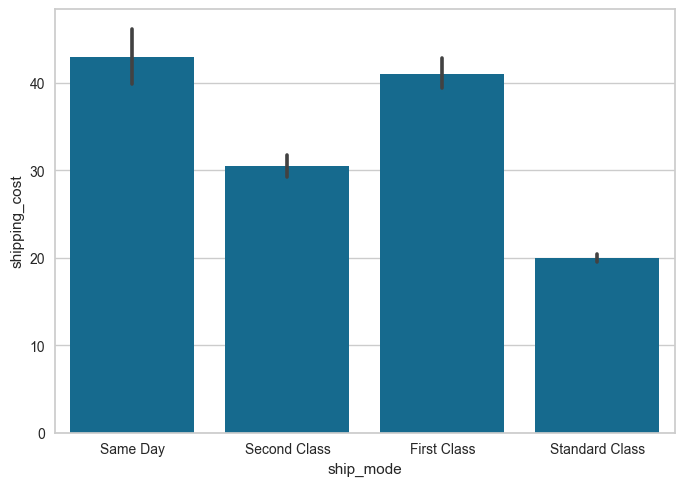

In [89]:
sns.barplot(data=global_superstore,
            x="ship_mode",
            y="shipping_cost",
            estimator="mean")

## Order level

In [ ]:
order_sales = (global_superstore
                .groupby("order_id")[["sales","profit","quantity","discounted_price","shipping_cost"]]
                .agg(
                    sales=("sales","sum"),
                    profit=("profit","sum"),
                    quantity=("quantity","sum"),
                    discounted_price=("discounted_price","sum"),
                    shipping_cost=("shipping_cost","sum")))

order_sales["profit_prop"] = order_sales["profit"] / order_sales["sales"] 
order_sales["discount"] = order_sales["discounted_price"] / (order_sales["discounted_price"] + order_sales["sales"])

order_sales.describe().T

count        mean         std          min       25%  \
sales             25035.0  504.993086  807.070936     0.556000  63.50925   
profit            25035.0   58.616229  275.302973 -6892.374800   0.00000   
quantity          25035.0    7.122508    6.156871     1.000000   3.00000   
discounted_price  25035.0   94.427335  327.636917     0.000000   0.00000   
shipping_cost     25035.0   54.037176   95.961036     0.000000   5.71500   
profit_prop       25035.0    0.047601    0.440353    -3.850924   0.00000   
discount          25035.0    0.144203    0.206658     0.000000   0.00000   

                         50%         75%         max  
sales             206.820000  615.575100  23661.2280  
profit             20.070000   89.173700   8762.3891  
quantity            5.000000    9.000000     58.0000  
discounted_price    0.000000   67.080000  23510.1420  
shipping_cost      19.470000   59.635000   2076.6200  
profit_prop         0.167881    0.307823      0.5000  
discount            0.000000    0.200000      0.8500

<Axes: >

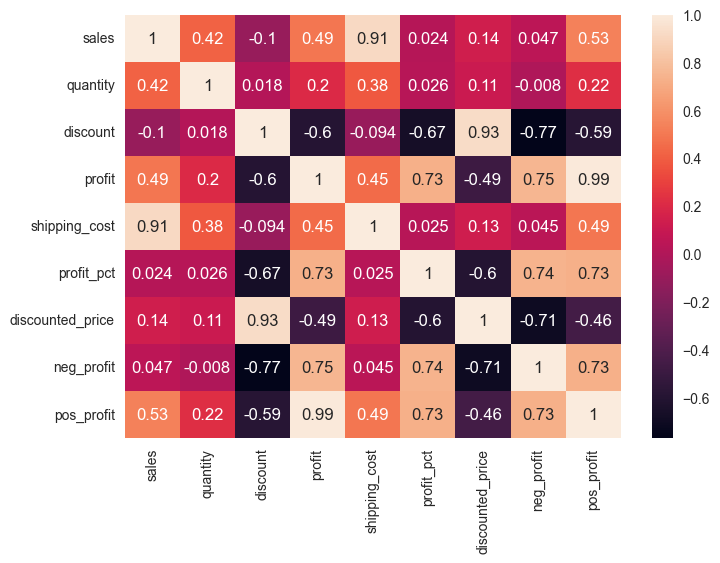

In [ ]:
sns.heatmap(global_superstore.corr(numeric_only=True, method="spearman"),annot=True)

<Axes: >

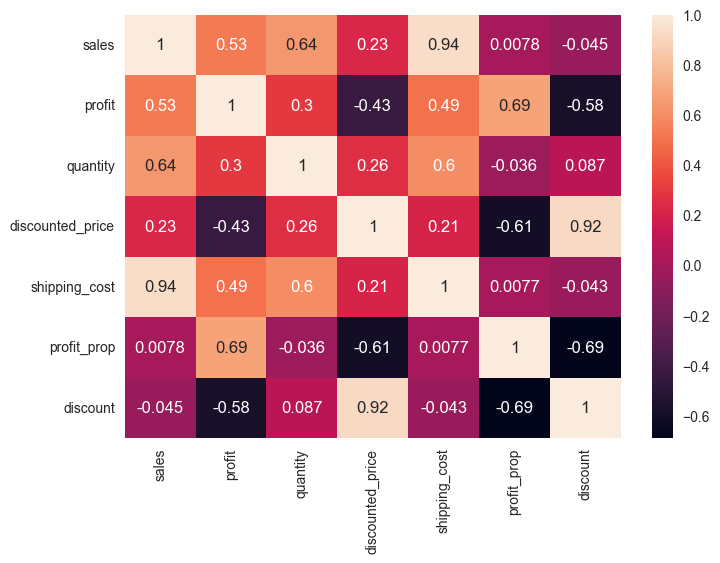

In [ ]:
sns.heatmap(order_sales.corr(numeric_only=True,method="spearman"), annot=True)

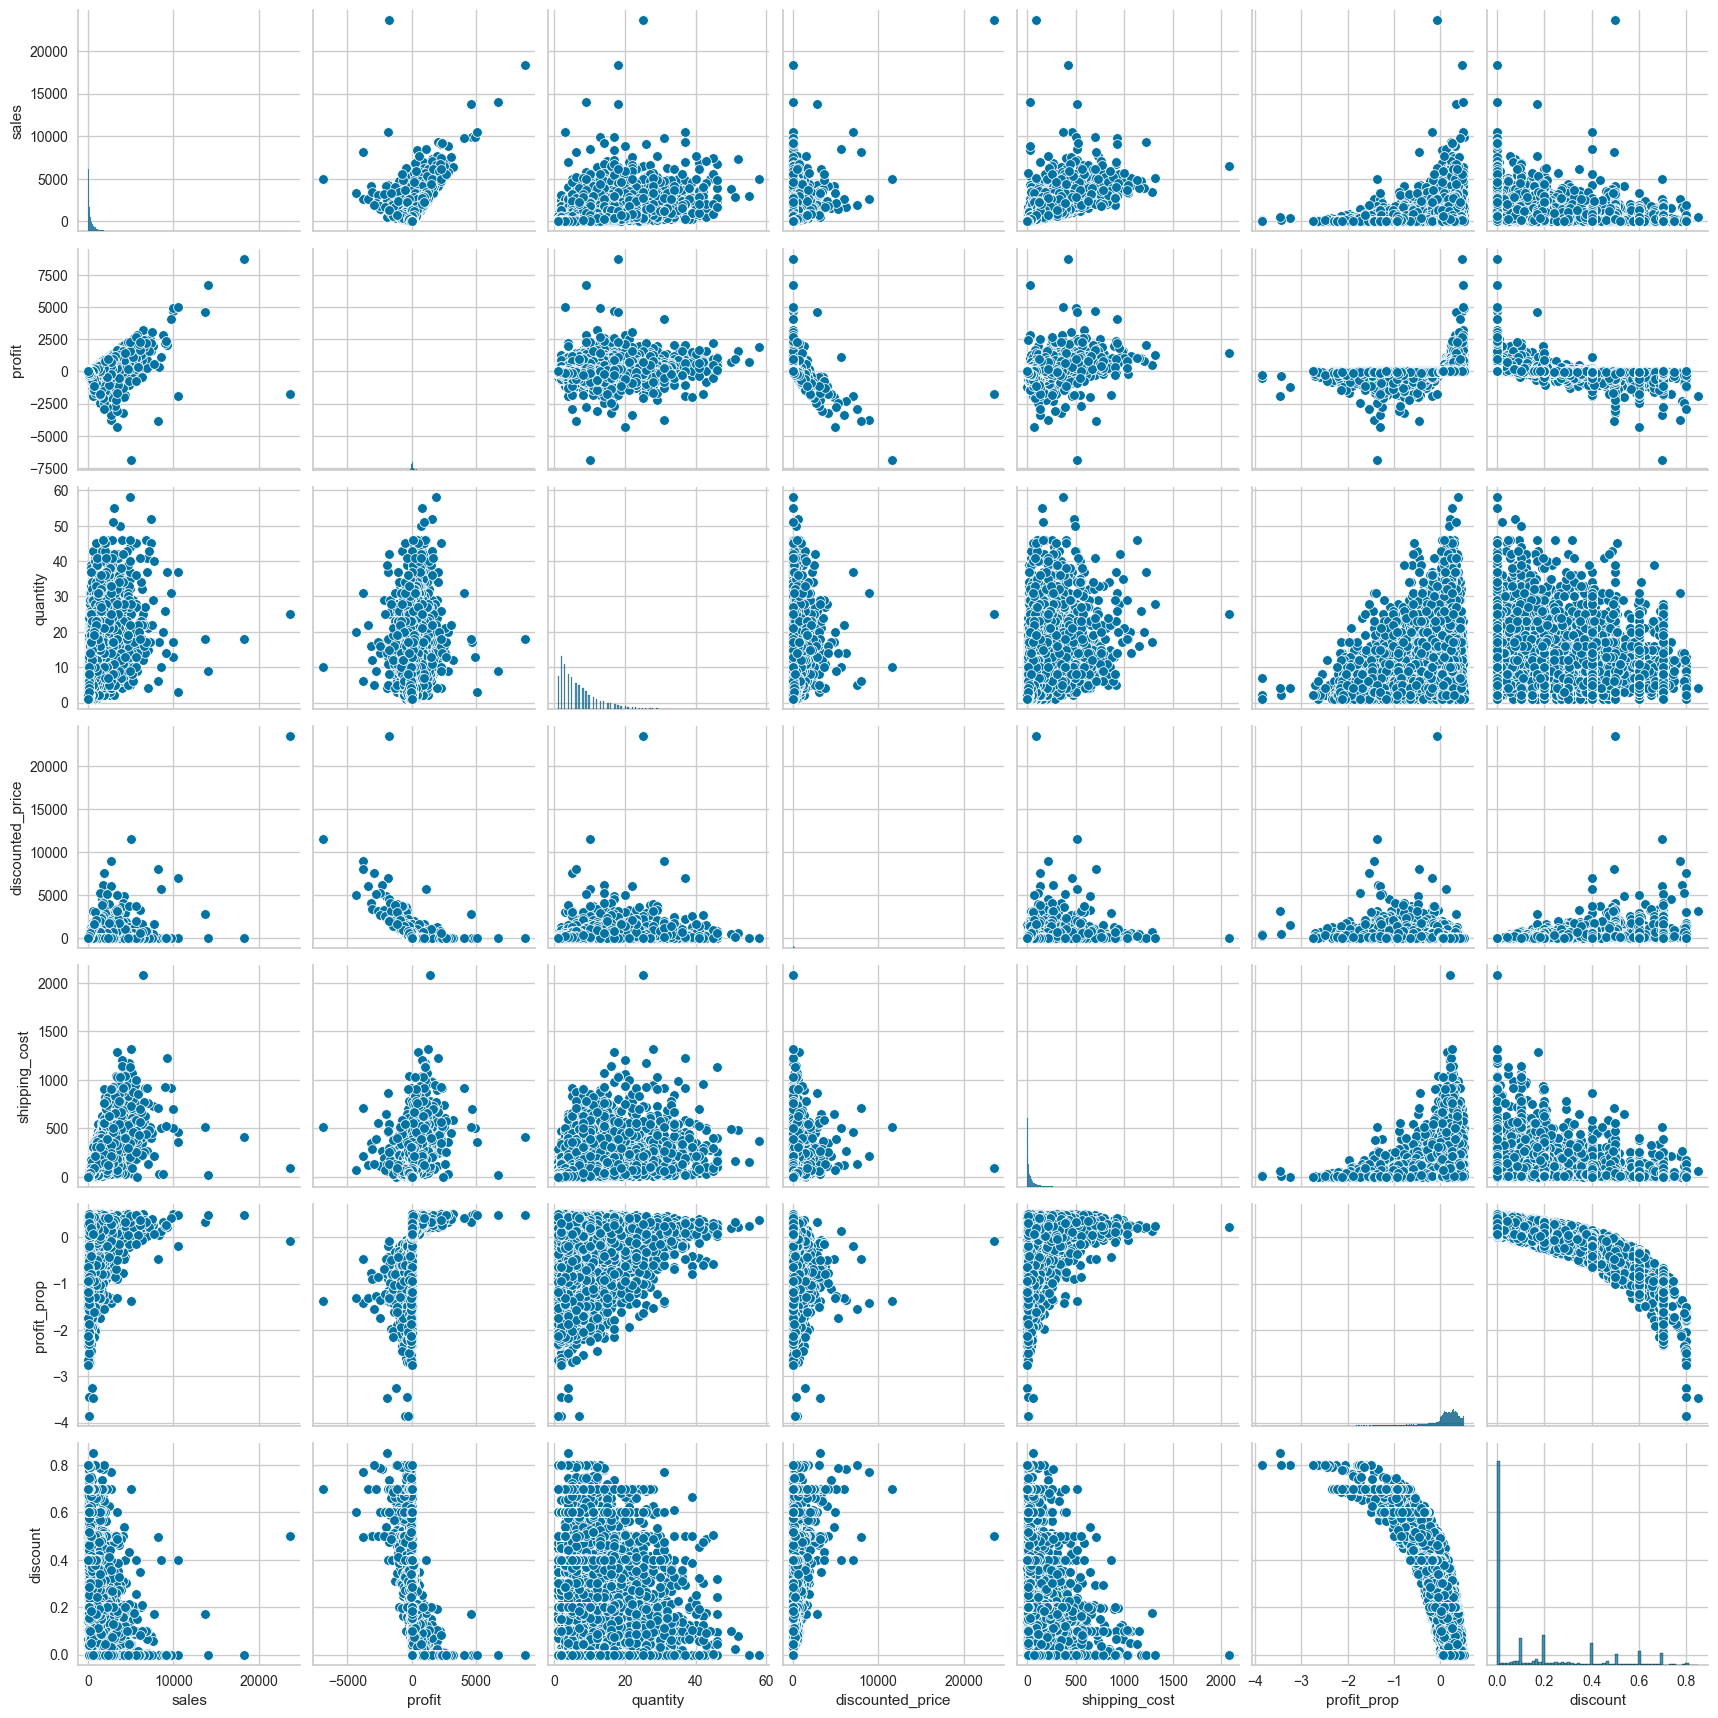

In [ ]:
sns.pairplot(order_sales)

In [ ]:
global_superstore.loc[:,["shipping_cost","sales","discount","profit"]]

shipping_cost     sales  discount    profit
0             933.57  2309.650       0.0  762.1845
1             923.63  3709.395       0.1 -288.7650
2             915.49  5175.171       0.1  919.9710
3             910.16  2892.510       0.1  -96.5400
4             903.04  2832.960       0.0  311.5200
...              ...       ...       ...       ...
51285           0.01    65.100       0.0    4.5000
51286           0.01     0.444       0.8   -1.1100
51287           0.01    22.920       0.0   11.2308
51288           0.00    13.440       0.0    2.4000
51289           0.00    61.380       0.0    1.8000

[51290 rows x 4 columns]

In [ ]:
global_superstore["is_discount"] = np.where(global_superstore["discount"] > 0,1,0)

In [ ]:
global_superstore["original_price"] = global_superstore["discounted_price"] + global_superstore["sales"]
global_superstore["discounted_shipping"] = global_superstore["shipping_cost"]/(1-global_superstore["discount"]) - global_superstore["shipping_cost"]
global_superstore["profit_before_discounts"] = global_superstore["discounted_shipping"] + global_superstore["discounted_price"] + global_superstore["profit"]
global_superstore["margin_wo_discount"] = global_superstore["profit_before_discounts"] / global_superstore["quantity"]
global_superstore["margin_discount"] = global_superstore["profit"] / global_superstore["quantity"]
# margin after discount is profit_prop


What are the most sold products? And what are their revenue and profits?

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14984\2470855372.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(product_sold_units.iloc[:10,:].index,rotation=45)


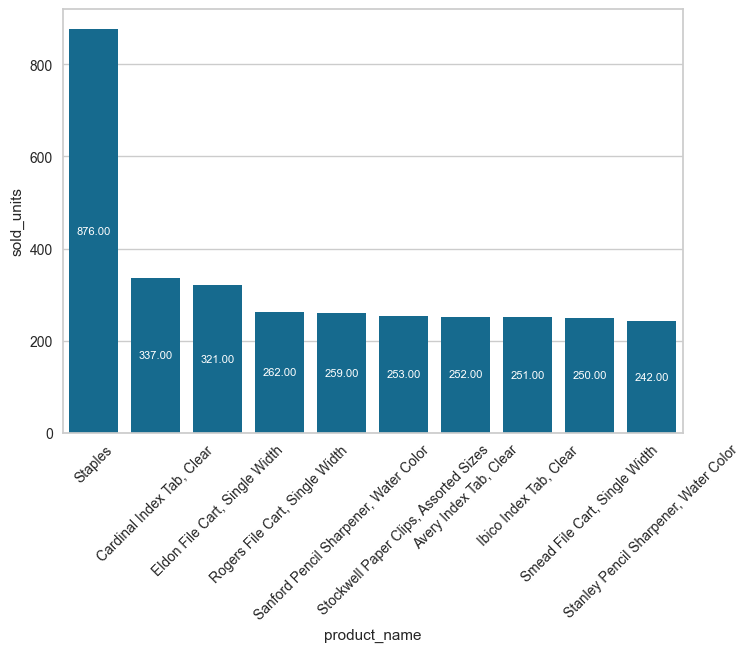

In [ ]:
product_sold_units = (global_superstore.groupby("product_name")[["quantity","profit","sales"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum")
                                                            )
                                                        .sort_values(by="sold_units",ascending=False))

ax= sns.barplot(data=product_sold_units.iloc[:10,:].reset_index(),
            x="product_name",
            y="sold_units")
ax.set_xticklabels(product_sold_units.iloc[:10,:].index,rotation=45)
dvs.plot_bar_labels(ax)

What products drive the most revenue?

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14984\2216897617.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(product_revenue.iloc[:10,:].index,rotation=45)


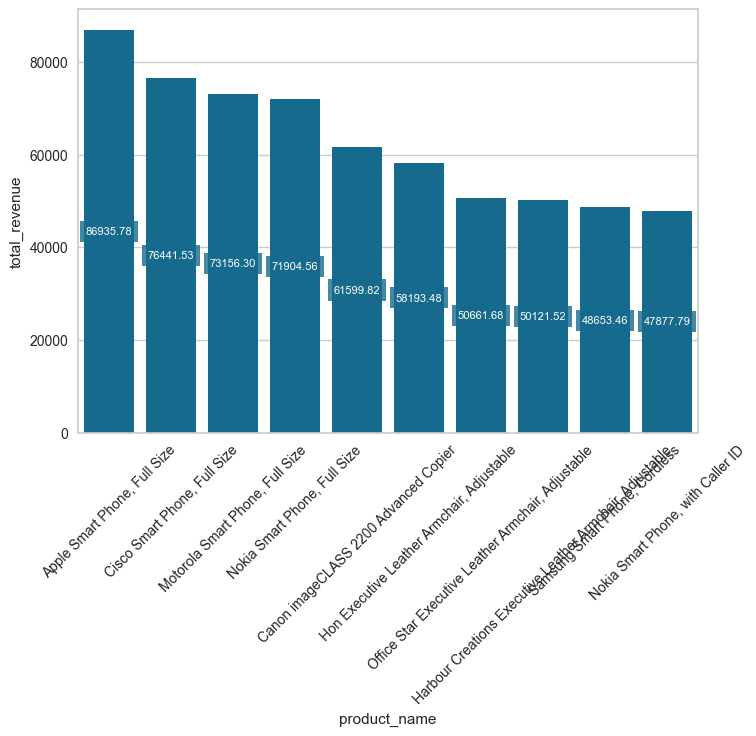

In [ ]:
product_revenue = (global_superstore.groupby("product_name")[["quantity","profit","sales"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum")
                                                            )
                                                        .sort_values(by="total_revenue",ascending=False))

ax= sns.barplot(data=product_revenue.iloc[:10,:].reset_index(),
            x="product_name",
            y="total_revenue")
ax.set_xticklabels(product_revenue.iloc[:10,:].index,rotation=45)
dvs.plot_bar_labels(ax)

What are the most profitable?

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14984\157762280.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(products_profit.iloc[:10,:].index,rotation=45)


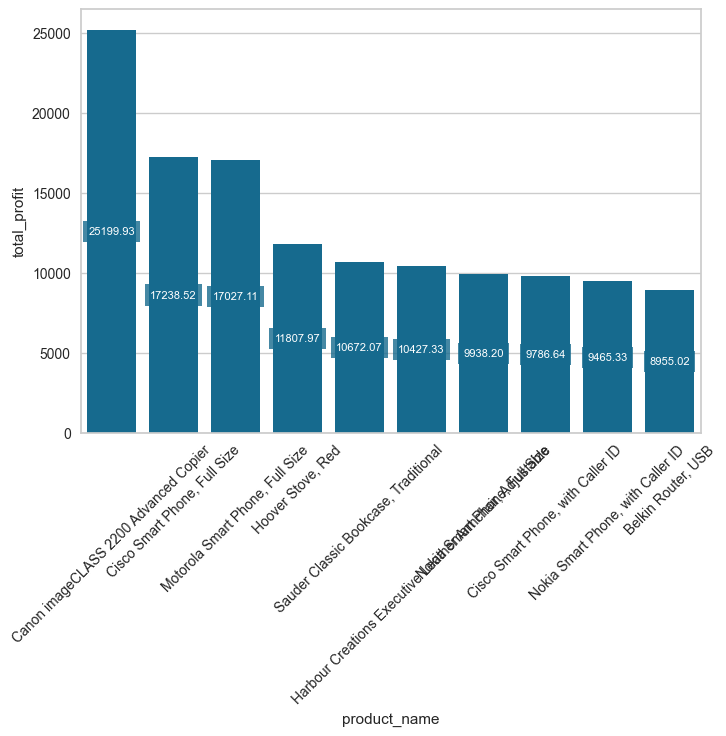

In [ ]:
products_profit = (global_superstore.groupby("product_name")[["quantity","profit","sales"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum")
                                                            )
                                                        .sort_values(by="total_profit",ascending=False))

ax= sns.barplot(data=products_profit.iloc[:10,:].reset_index(),
            x="product_name",
            y="total_profit")
ax.set_xticklabels(products_profit.iloc[:10,:].index,rotation=45)
dvs.plot_bar_labels(ax)

**Q**: What is order priority caused by?

Order priority vs discount.

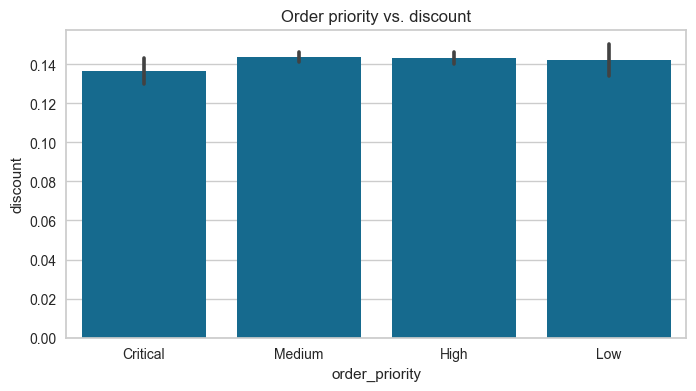

In [ ]:
plt.figure(figsize=(8,4))
plt.title("Order priority vs. discount")
sns.barplot(data=global_superstore,
            x="order_priority",
            y="discount",
            estimator="mean")
plt.show()

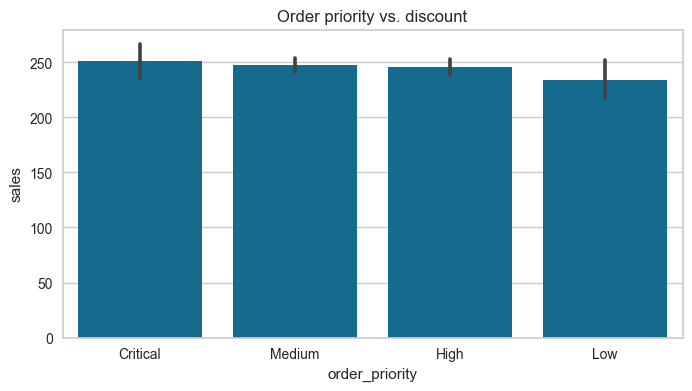

In [ ]:
plt.figure(figsize=(8,4))
plt.title("Order priority vs. discount")
sns.barplot(data=global_superstore,
            x="order_priority",
            y="sales",
            estimator="mean")
plt.show()

What are the most sold categories? In the 3 years of activity

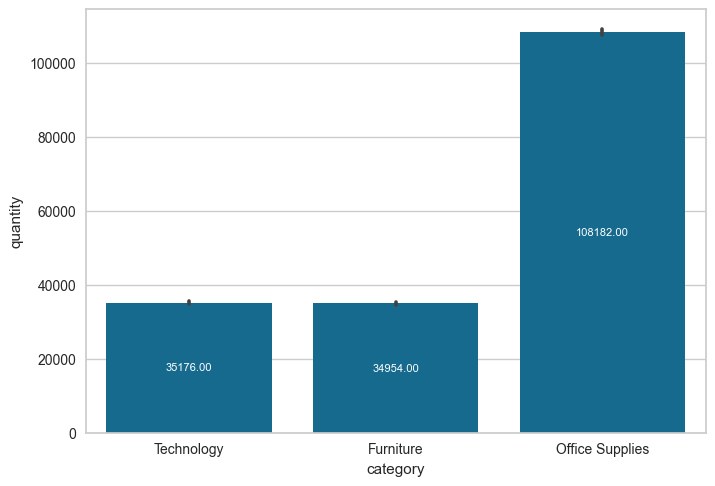

In [ ]:
ax = sns.barplot(data=global_superstore,
            x="category",
            y="quantity",
            estimator="sum")

dvs.plot_bar_labels(ax)

What are the biggest revenue drivers?

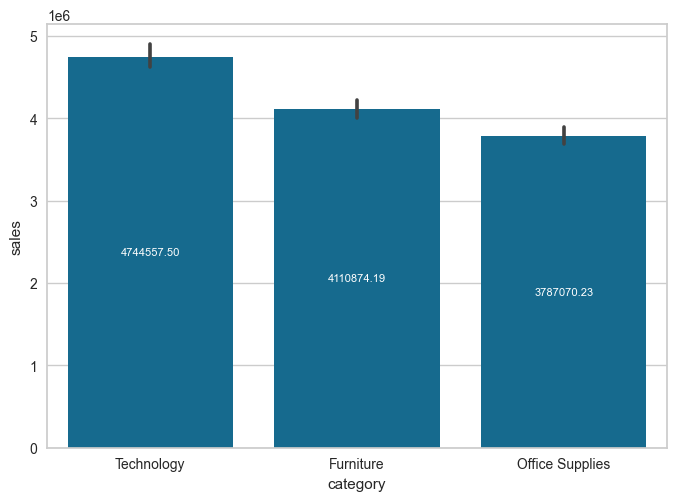

In [ ]:
ax= sns.barplot(data=global_superstore,
            x="category",
            y="sales",
            estimator="sum")
dvs.plot_bar_labels(ax)

What are the biggest profit drivers?

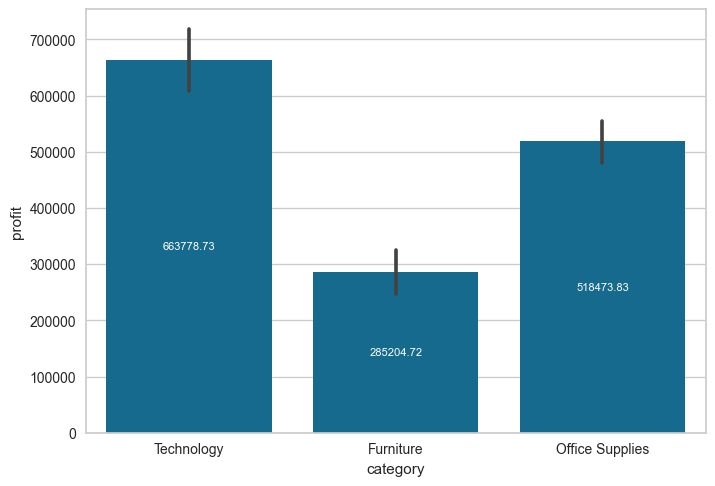

In [ ]:
ax= sns.barplot(data=global_superstore,
            x="category",
            y="profit",
            estimator="sum")
dvs.plot_bar_labels(ax)

What are the ones with the biggest margins?

Plot this with a waterfall cash-flow plot or a stacked plot

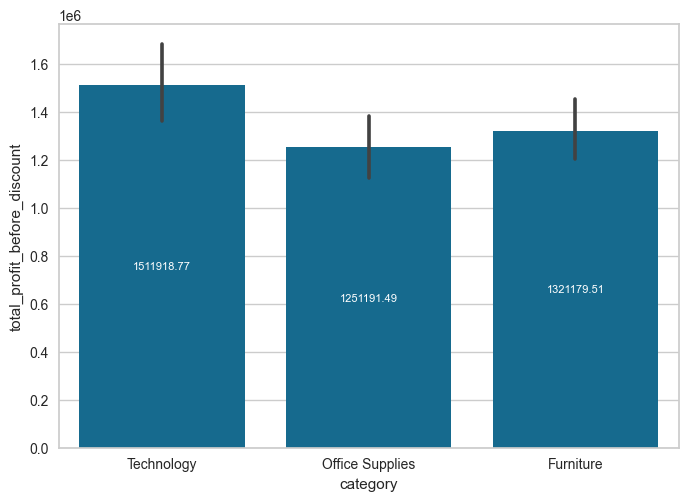

In [ ]:
products_profit = (global_superstore.groupby(["product_name","category"])[["quantity","profit","sales","profit_before_discounts","discounted_price","margin_wo_discount"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                        .sort_values(by="total_profit",ascending=False))

ax= sns.barplot(data=products_profit,
            x="category",
            y="total_profit_before_discount",
            estimator="sum")
dvs.plot_bar_labels(ax)

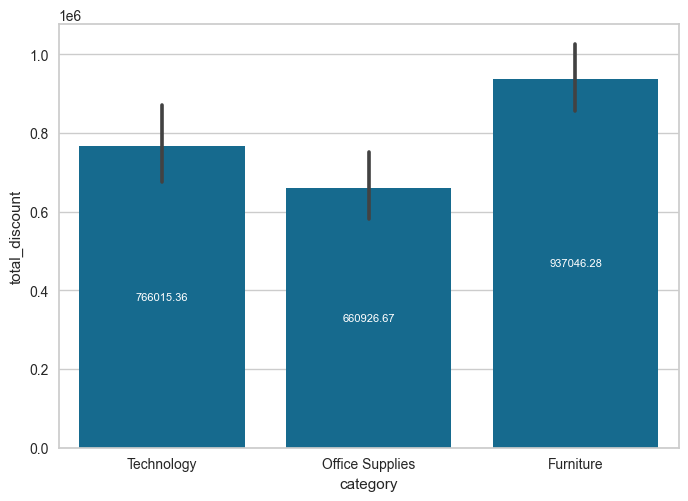

In [ ]:
products_profit = (global_superstore.groupby(["product_name","category"])[["quantity","profit","sales","profit_before_discounts","discounted_price","margin_wo_discount"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                        .sort_values(by="total_profit",ascending=False))

ax= sns.barplot(data=products_profit,
            x="category",
            y="total_discount",
            estimator="sum")
dvs.plot_bar_labels(ax)

Most profitable in proportion?

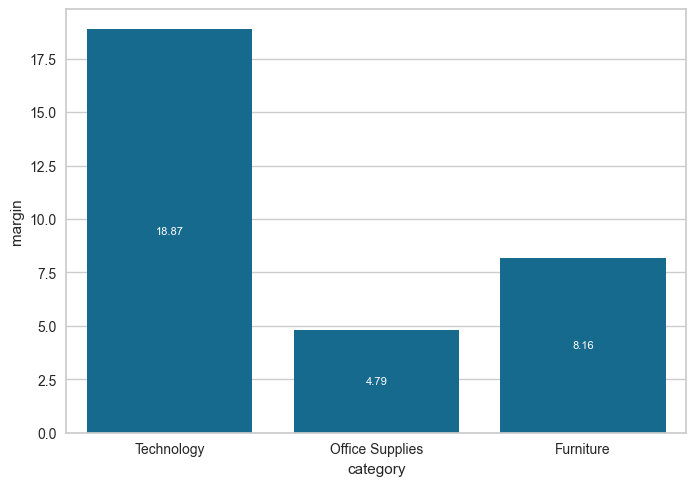

In [ ]:
products_profit = (global_superstore.groupby(["category"])[["quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price","margin_wo_discount", "margin_discount"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"])
                                                        .sort_values(by="total_profit",ascending=False))


ax= sns.barplot(data=products_profit,
            x="category",
            y="margin",
            estimator="mean")
dvs.plot_bar_labels(ax)

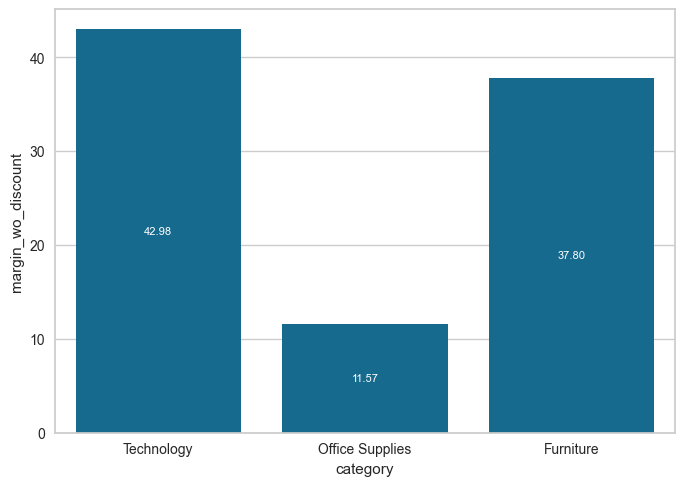

In [ ]:
products_profit = (global_superstore.groupby(["category"])[["quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price","margin_wo_discount", "margin_discount"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"])
                                                        .sort_values(by="total_profit",ascending=False))


ax= sns.barplot(data=products_profit,
            x="category",
            y="margin_wo_discount",
            estimator="mean")
dvs.plot_bar_labels(ax)

And the same, differentiated by year?

Is there any particular product that sells more during different times of the year?

What are the most sold subcategories?

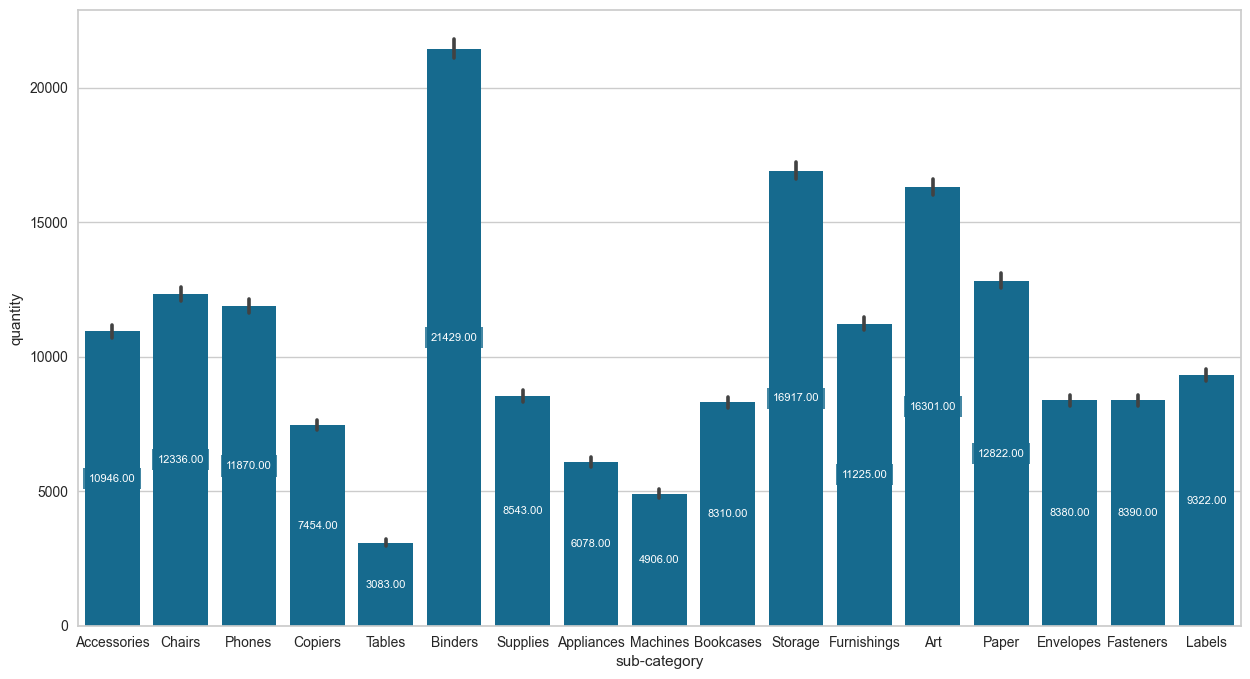

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=global_superstore,
            x="sub-category",
            y="quantity",
            estimator="sum")
dvs.plot_bar_labels(ax)

What are the most revenue drivers?

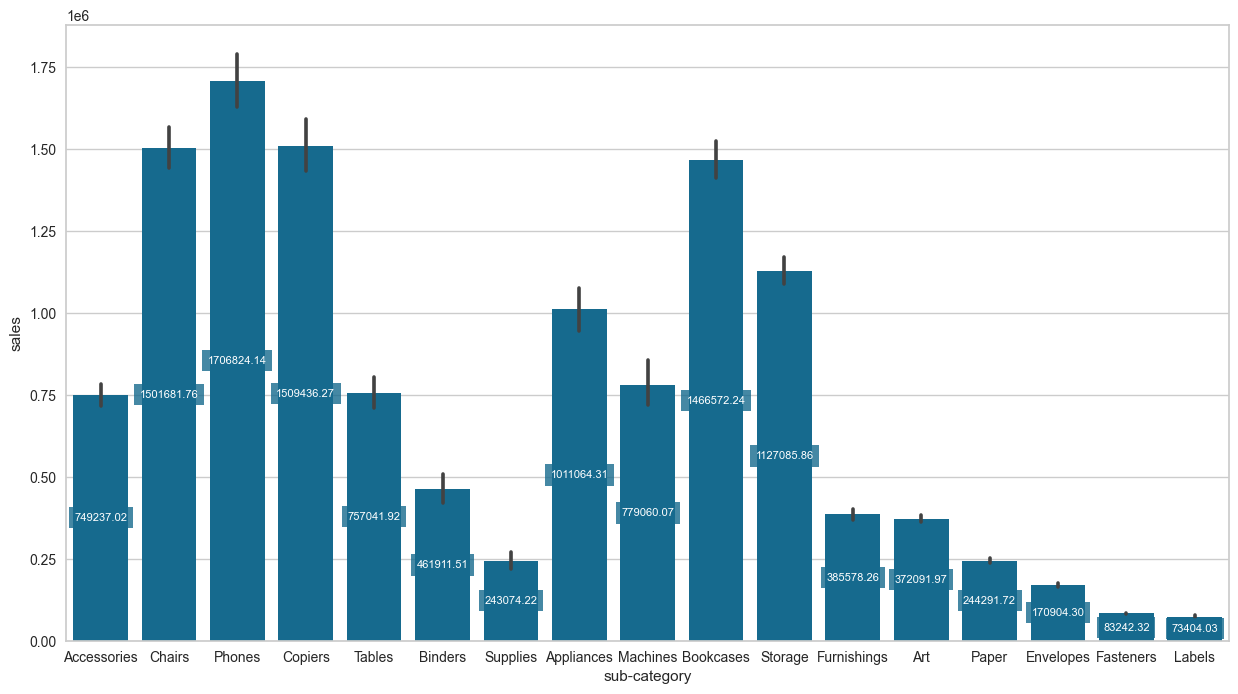

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=global_superstore,
            x="sub-category",
            y="sales",
            estimator="sum")
dvs.plot_bar_labels(ax)

What are the biggest profit drivers?

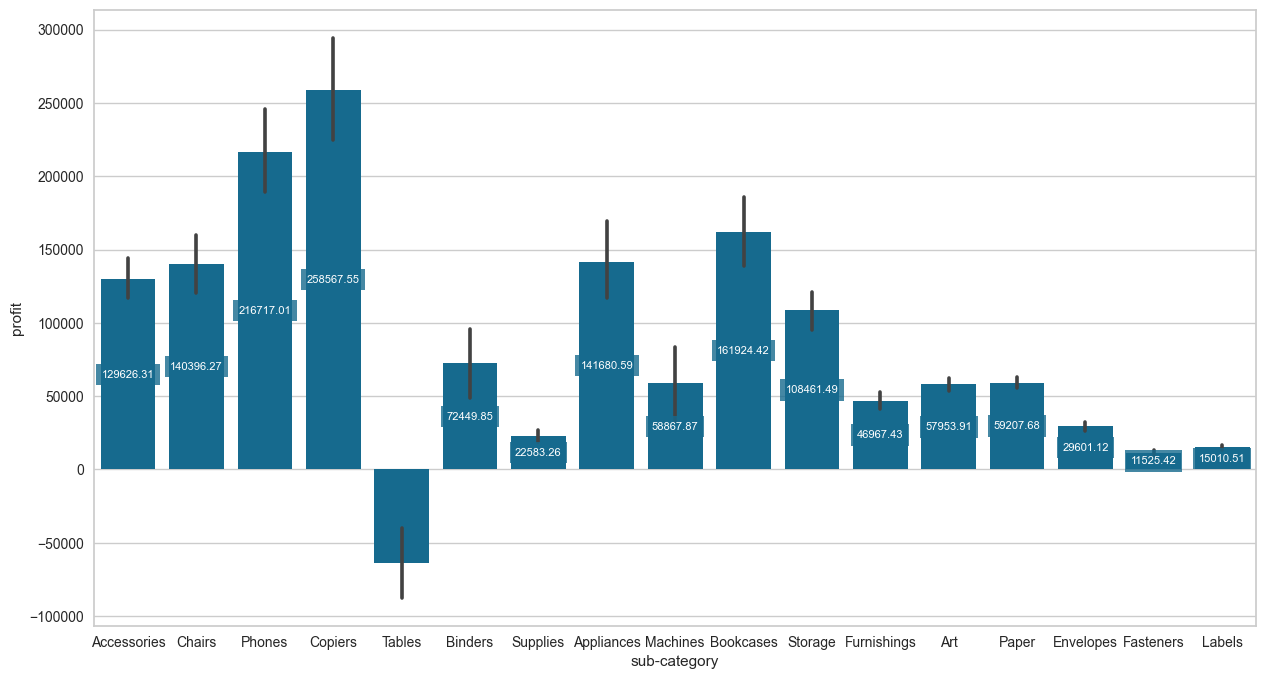

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=global_superstore,
            x="sub-category",
            y="profit",
            estimator="sum")
dvs.plot_bar_labels(ax)

In margins?

In [ ]:
subcategory_profit = (global_superstore.groupby(["sub-category"])[["quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price","margin_wo_discount", "margin_discount"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"],
                                                                    avg_discount=lambda df: df["total_discount"]/df["total_revenue"])
                                                        .sort_values(by="margin",ascending=False))

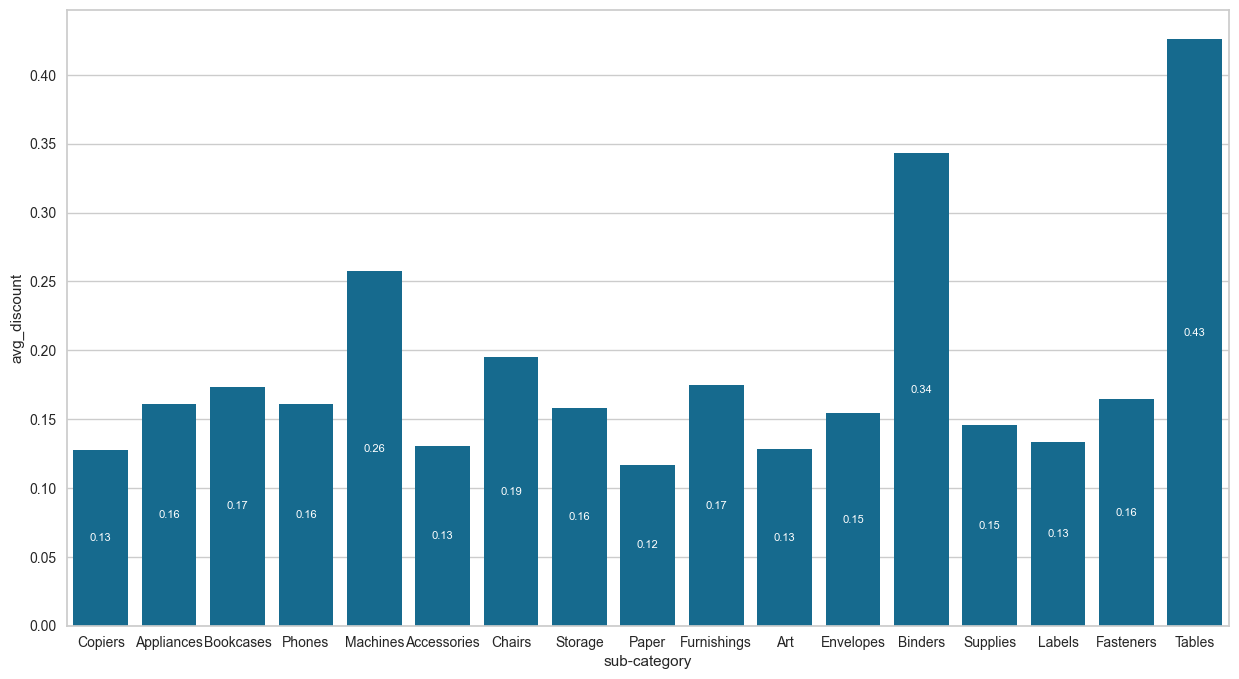

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=subcategory_profit,
            x="sub-category",
            y="avg_discount",
            estimator="mean",
            order=subcategory_profit.index)
dvs.plot_bar_labels(ax)

After discounts

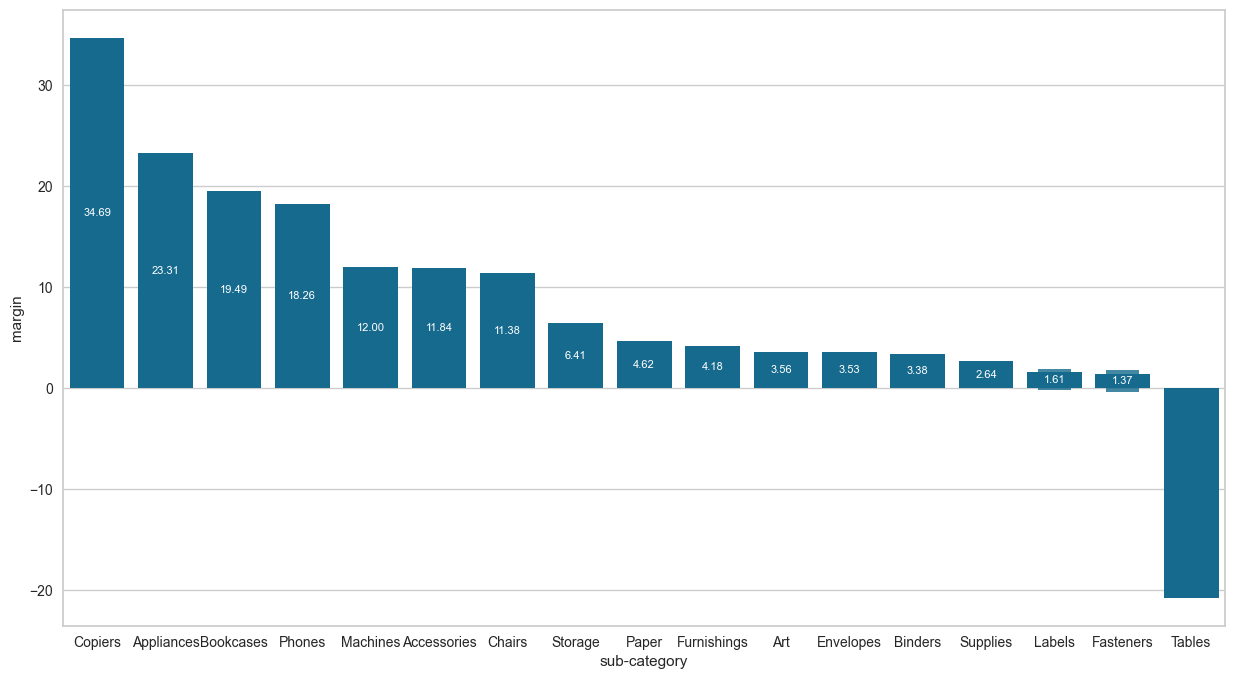

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=subcategory_profit,
            x="sub-category",
            y="margin",
            estimator="mean",
            order=subcategory_profit.index)
dvs.plot_bar_labels(ax)

Before discounts

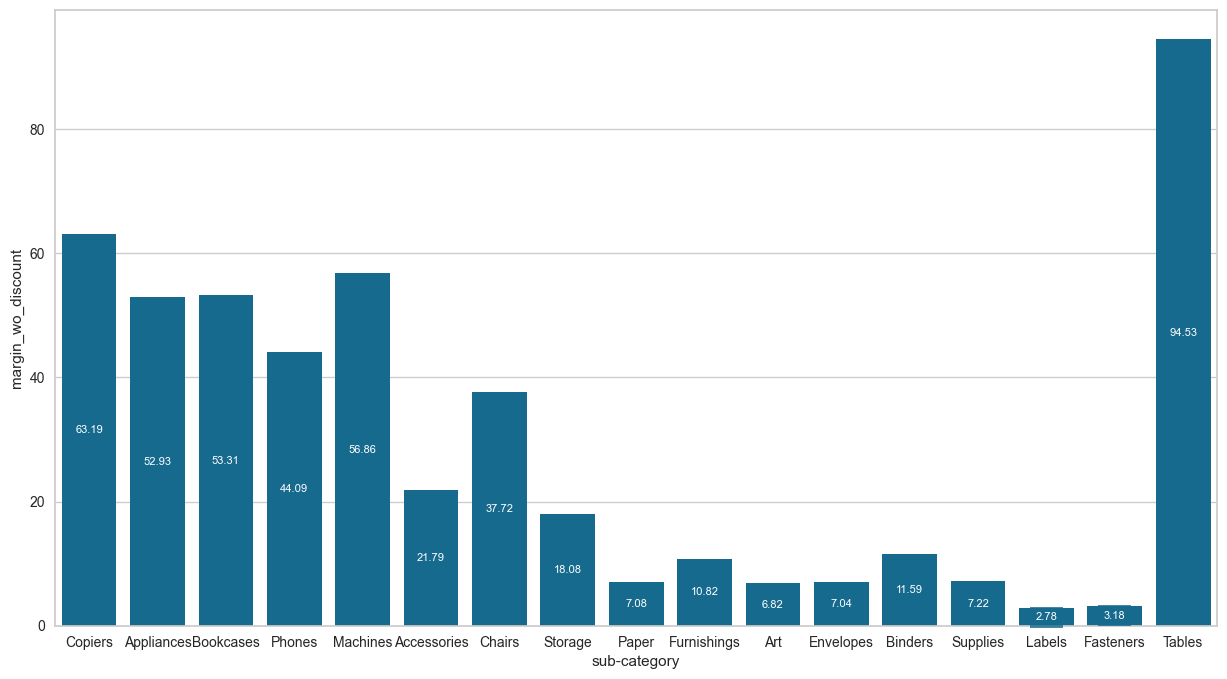

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=subcategory_profit,
            x="sub-category",
            y="margin_wo_discount",
            estimator="mean")
dvs.plot_bar_labels(ax)

And the least?

### Segments

In [ ]:
segments_aggregation = (global_superstore.groupby(["segment"])[["quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"])
                                                        .sort_values(by="total_profit",ascending=False))


Quantities

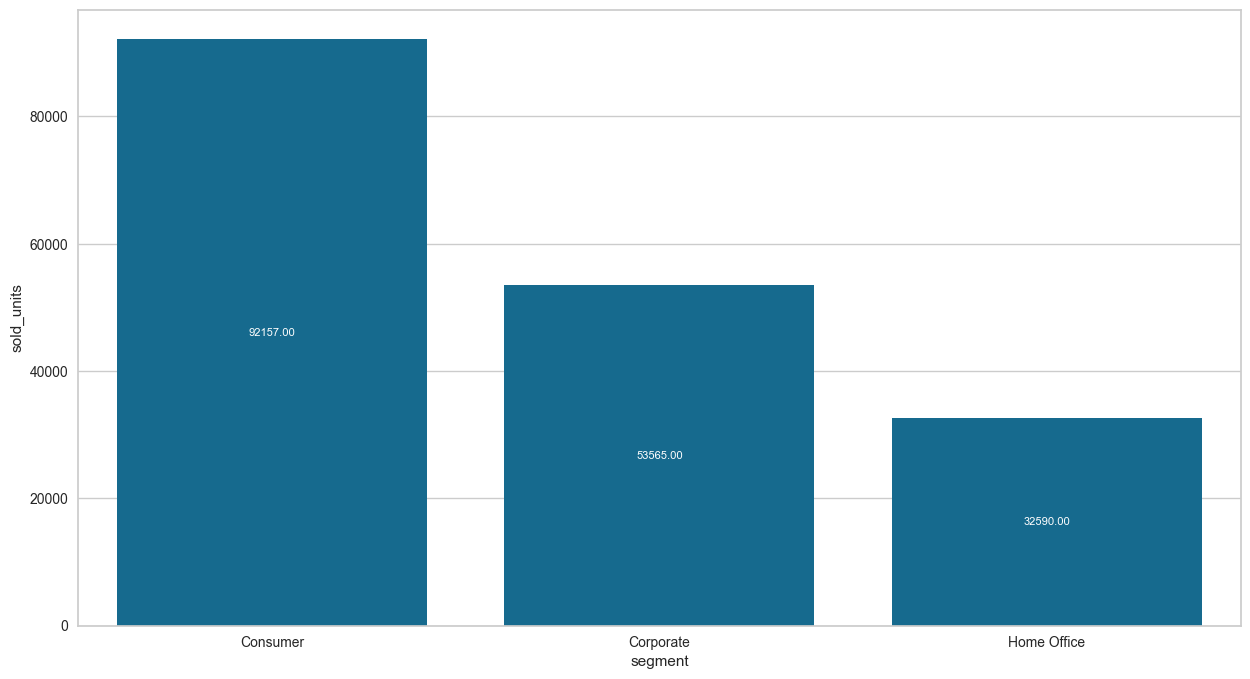

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="sold_units",
            estimator="sum")
dvs.plot_bar_labels(ax)

Sales

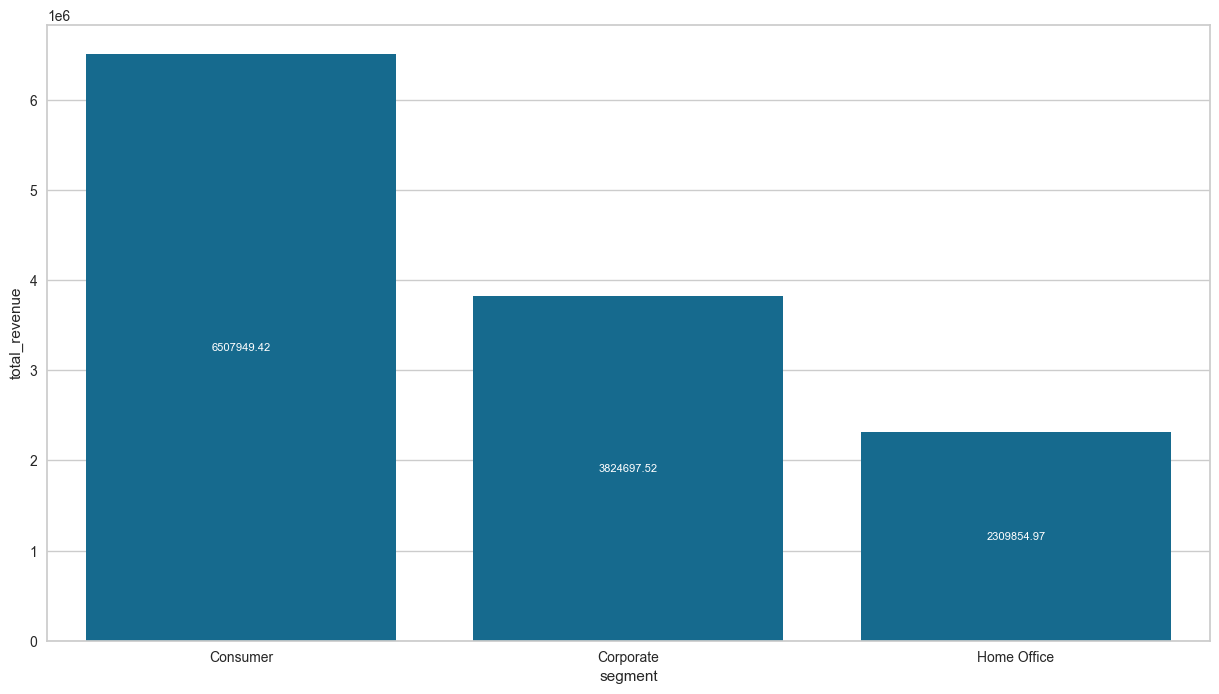

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="total_revenue",
            estimator="sum")
dvs.plot_bar_labels(ax)

Profit

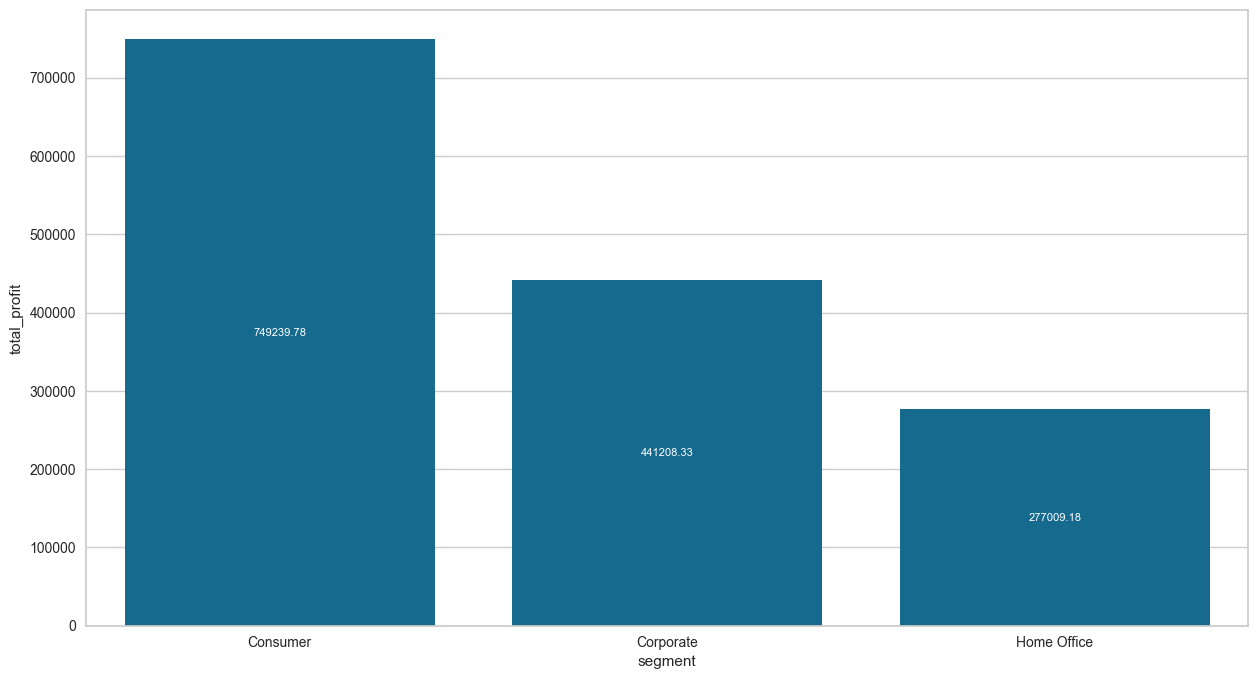

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="total_profit",
            estimator="sum")
dvs.plot_bar_labels(ax)

Margin

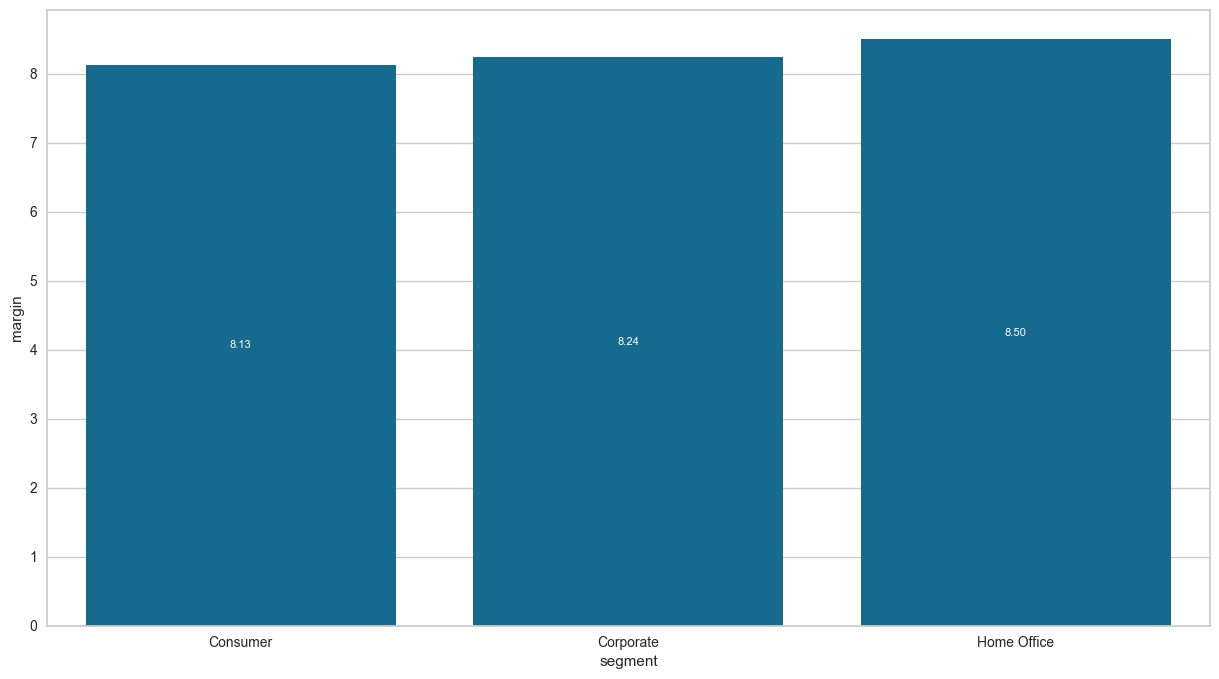

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="margin",
            estimator="mean")
dvs.plot_bar_labels(ax)

Margin without discount

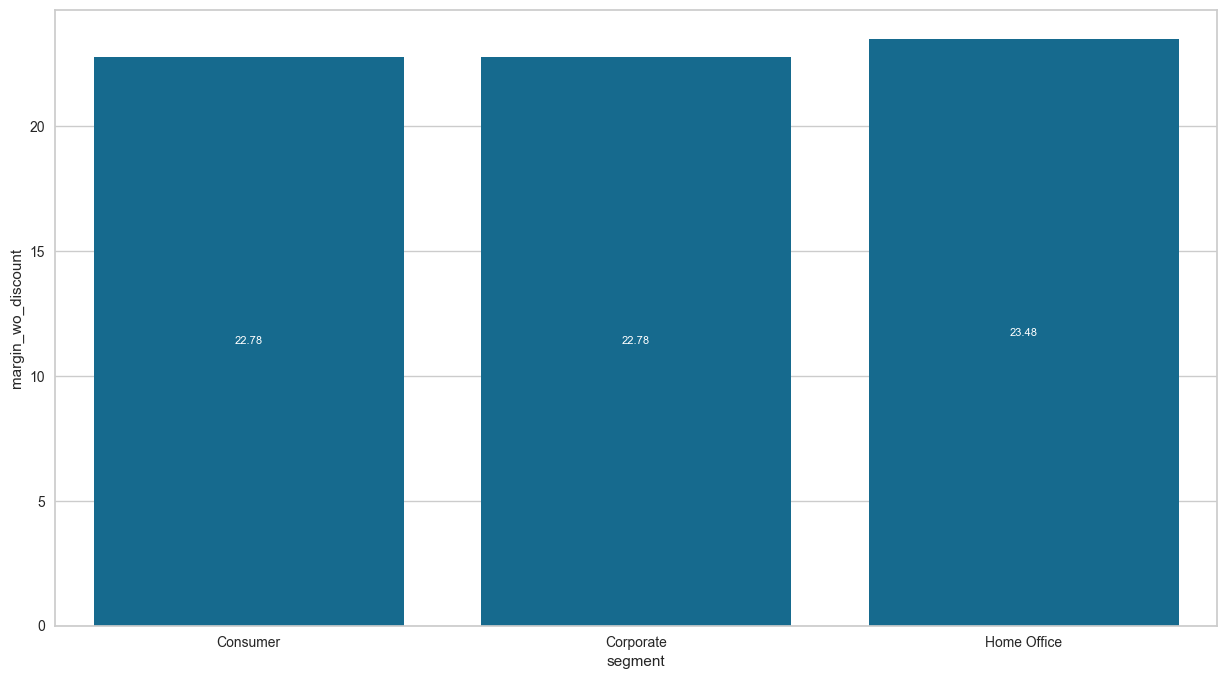

In [ ]:
plt.figure(figsize=(15,8))
ax= sns.barplot(data=segments_aggregation,
            x="segment",
            y="margin_wo_discount",
            estimator="sum")
dvs.plot_bar_labels(ax)

### Ship mode and priority

Is there a correlation between shipmode and sales?

In [ ]:
ship_modes_aggregation = (global_superstore.groupby(["ship_mode"])[["quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price"]].agg(
                                                            sold_units=("quantity","sum"),
                                                            total_revenue=("sales","sum"),
                                                            total_profit=("profit","sum"),
                                                            total_discount=("discounted_price","sum"),
                                                            total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["sold_units"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["sold_units"])
                                                        .sort_values(by="total_profit",ascending=False))




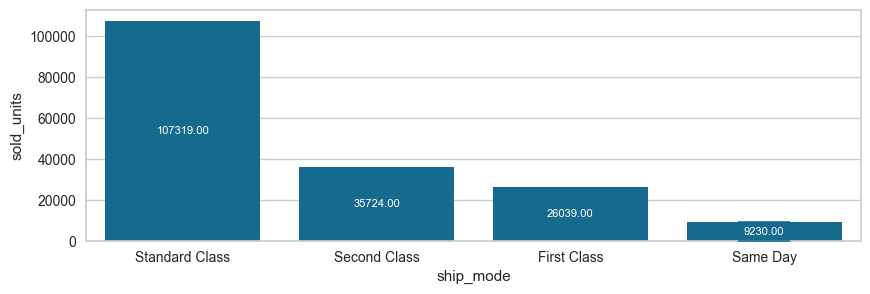

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=ship_modes_aggregation,
            x="ship_mode",
            y="sold_units",
            estimator="sum")
dvs.plot_bar_labels(ax)

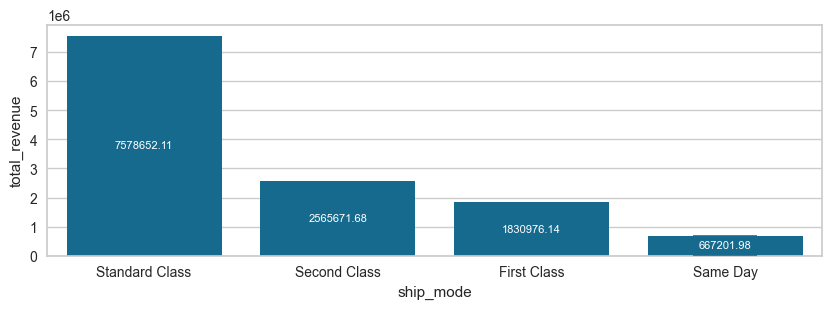

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=ship_modes_aggregation,
            x="ship_mode",
            y="total_revenue",
            estimator="sum")
dvs.plot_bar_labels(ax)

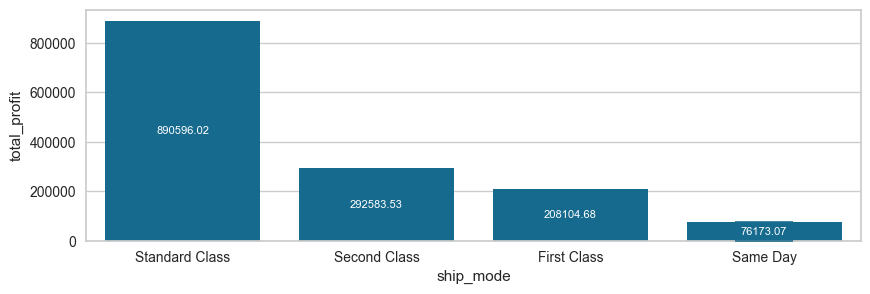

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=ship_modes_aggregation,
            x="ship_mode",
            y="total_profit",
            estimator="sum")
dvs.plot_bar_labels(ax)

### Order priority

In [ ]:
order_priority_aggregation = (global_superstore.groupby(["order_priority"])[["order_id","quantity","profit","sales","profit_before_discounts",
                                                                           "discounted_price"]].agg(
                                                                total_orders=("order_id","nunique"),
                                                                sold_units=("quantity","sum"),
                                                                total_revenue=("sales","sum"),
                                                                avg_revenue=("sales","mean"),
                                                                total_profit=("profit","sum"),
                                                                total_discount=("discounted_price","sum"),
                                                                total_profit_before_discount=("profit_before_discounts","sum")
                                                            )
                                                            .assign(margin=lambda df: df["total_profit"]/df["total_orders"],
                                                                    margin_wo_discount=lambda df: df["total_profit_before_discount"]/df["total_orders"],
                                                                    avg_revenue=lambda df: df["total_revenue"]/df["total_orders"])
                                                        .sort_values(by="total_profit",ascending=False))

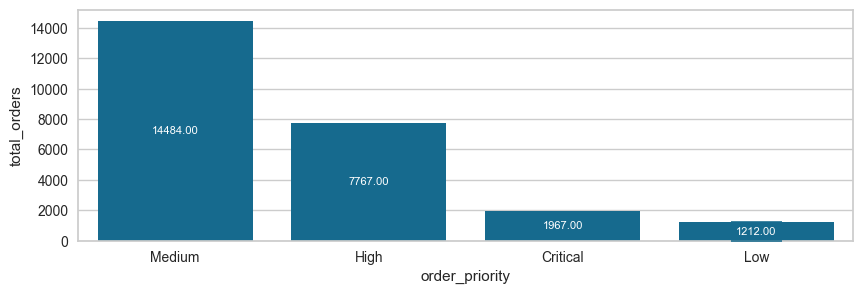

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="total_orders",
            estimator="sum")
dvs.plot_bar_labels(ax)

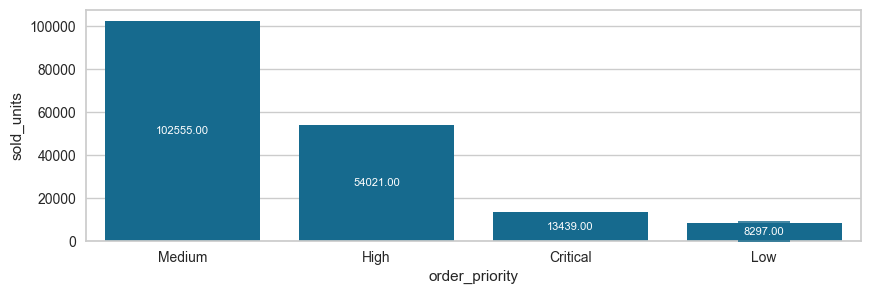

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="sold_units",
            estimator="sum")
dvs.plot_bar_labels(ax)

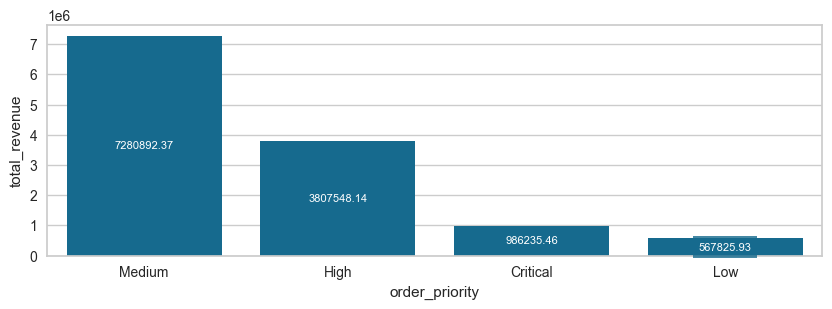

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="total_revenue",
            estimator="sum")
dvs.plot_bar_labels(ax)

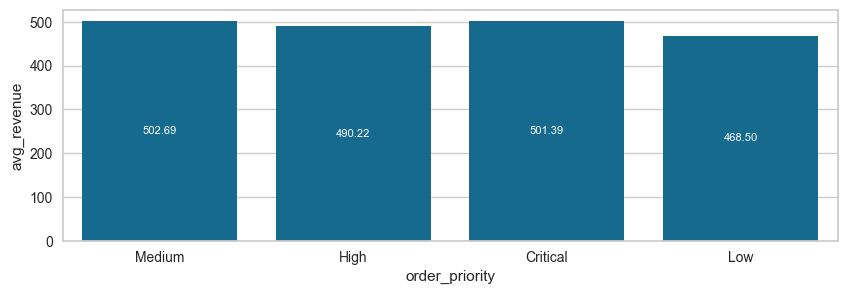

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="avg_revenue",
            estimator="sum")
dvs.plot_bar_labels(ax)

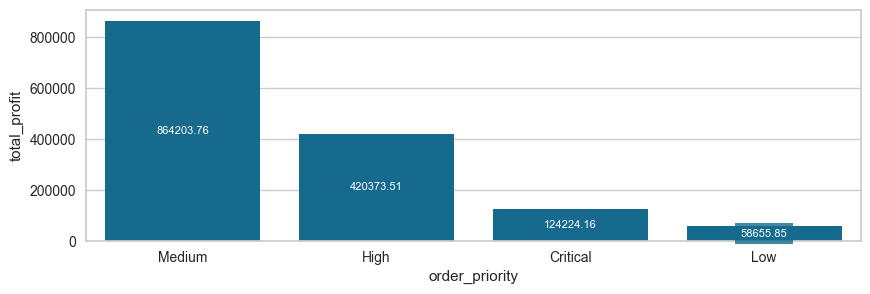

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="total_profit",
            estimator="sum")
dvs.plot_bar_labels(ax)

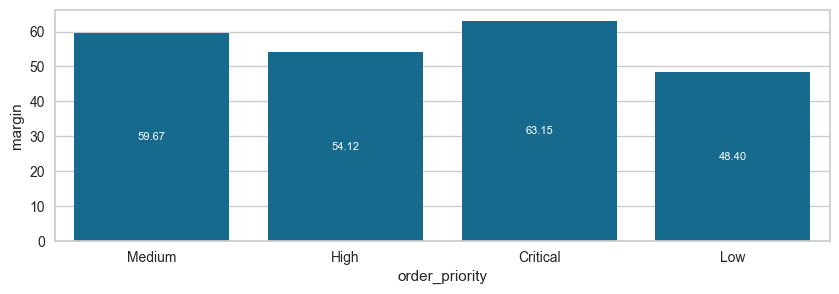

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="margin",
            estimator="sum")
dvs.plot_bar_labels(ax)

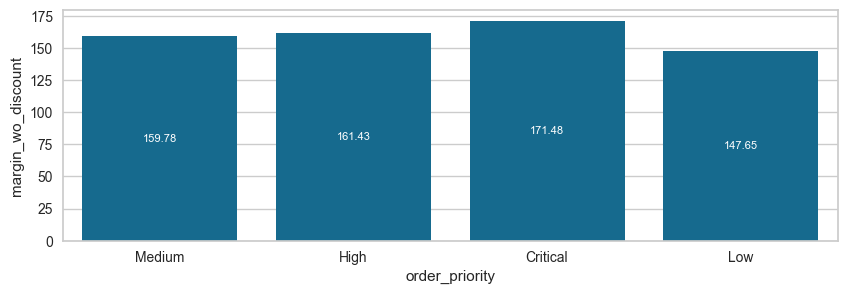

In [ ]:
plt.figure(figsize=(10,3))
ax= sns.barplot(data=order_priority_aggregation,
            x="order_priority",
            y="margin_wo_discount",
            estimator="sum")
dvs.plot_bar_labels(ax)

Order priority is neither correlated with margins nor with avg revenue per order. Therefore, if it is not correlated with some customers or we are unable to find that relationship, then it should not be included in the model.

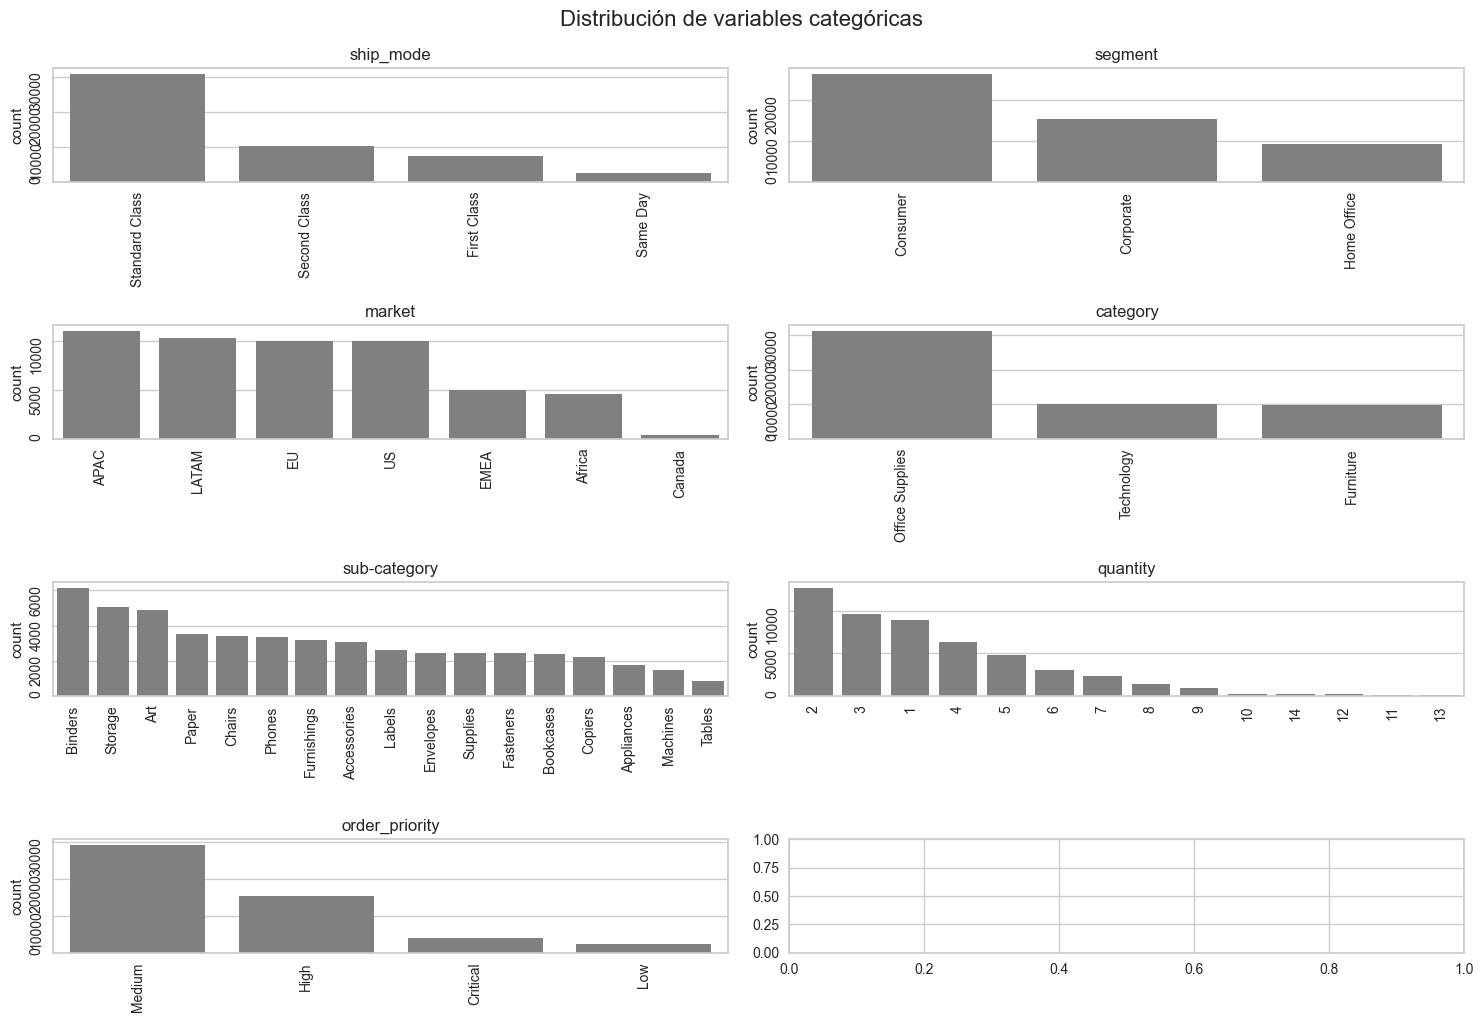

In [ ]:
visualizador.plot_categoricas(tamano_grafica=(15,10))

What are the products that bring more revenue?

What are the most discounted products?

What are the products that make us lose more money due to discounts by its shipping costs?

Prove that shipping costs are not inside sales but are discounted.

Are there products that are sold negative in profit to sell others? If orders are all negative, is that to promote more consumption?

When are certain products most sold?

Prove disfunctional discount cycles and correlation with sales.

When...

What 

### Product level

Check and calculate price per unit for products

If it does not depend on quantity (and only discount does), calculate margin

In [ ]:
global_superstore["original_ppu"] = (global_superstore["sales"] + global_superstore["discounted_price"]) / global_superstore["quantity"]

Cuantas filas hay con producto no descontado?

In [ ]:
(global_superstore["discount"] == 0).sum() / global_superstore.shape[0]

np.float64(0.5655878338857477)

What are the most sold products?

In [ ]:
global_superstore["product_name"].value_counts()

product_name
Staples                                                             227
Cardinal Index Tab, Clear                                            92
Eldon File Cart, Single Width                                        90
Rogers File Cart, Single Width                                       84
Ibico Index Tab, Clear                                               83
                                                                   ... 
4009 Highlighters                                                     1
Stride Job 150 Highlighters, Chisel Tip, Assorted Colors              1
Cisco 8961 IP Phone Charcoal                                          1
Xerox Blank Computer Paper                                            1
Eureka Disposable Bags for Sanitaire Vibra Groomer I Upright Vac      1
Name: count, Length: 3788, dtype: int64

In [ ]:
global_superstore[["product_name","original_ppu"]].value_counts()

product_name                                        original_ppu
Ibico Binder Covers, Clear                          13.11           39
Boston Canvas, Fluorescent                          54.90           38
Binney & Smith Sketch Pad, Blue                     46.32           37
Wilson Jones 3-Hole Punch, Durable                  29.49           37
Fellowes File Cart, Wire Frame                      136.38          37
                                                                    ..
Fiskars Trimmer, Easy Grip                          29.28            1
Jiffy Interoffice Envelope, with clear poly window  49.98            1
Fiskars Shears, Steel                               47.04            1
Jiffy Interoffice Envelope, Security-Tint           32.56            1
Jiffy Clasp Envelope, Set of 50                     5.68             1
Name: count, Length: 10996, dtype: int64

dkdkdkd

In [ ]:
product_sales = (global_superstore
                .groupby("product_id")[["sales","profit","quantity","discounted_price","shipping_cost", "original_ppu"]]
                .agg(
                    sales=("sales","sum"),
                    profit=("profit","sum"),
                    quantity=("quantity","sum"),
                    discounted_price=("discounted_price","sum"),
                    shipping_cost=("shipping_cost","sum"),
                    original_ppu=("shipping_cost","mean")))

product_sales["profit_prop"] = product_sales["profit"] / product_sales["sales"] 
product_sales["discount"] = product_sales["discounted_price"] / (product_sales["discounted_price"] + product_sales["sales"])

product_sales.describe().T

count         mean          std        min         25%  \
sales             3788.0  3337.513704  5915.960825     1.6240  314.102250   
profit            3788.0   387.396328  1176.634700 -8879.9704   14.989350   
quantity          3788.0    47.072862    40.672009     1.0000   18.000000   
discounted_price  3788.0   624.072946  1314.631075     0.0000   37.056000   
shipping_cost     3788.0   357.133234   633.519705     0.0200   33.157500   
original_ppu      3788.0    30.402836    50.006058     0.0200    3.701324   
profit_prop       3788.0     0.151388     0.209014    -2.7500    0.046124   
discount          3788.0     0.148859     0.111738     0.0000    0.080000   

                          50%          75%         max  
sales             1268.809000  3884.990250  86935.7786  
profit              97.048000   419.569050  25199.9280  
quantity            35.000000    67.000000    876.0000  
discounted_price   186.356250   659.957400  22638.4800  
shipping_cost      134.800000   405.635000   8817.3400  
original_ppu        11.342917    35.238940    674.8200  
profit_prop          0.164706     0.277648      0.5000  
discount             0.127273     0.187691      0.8000

<Axes: >

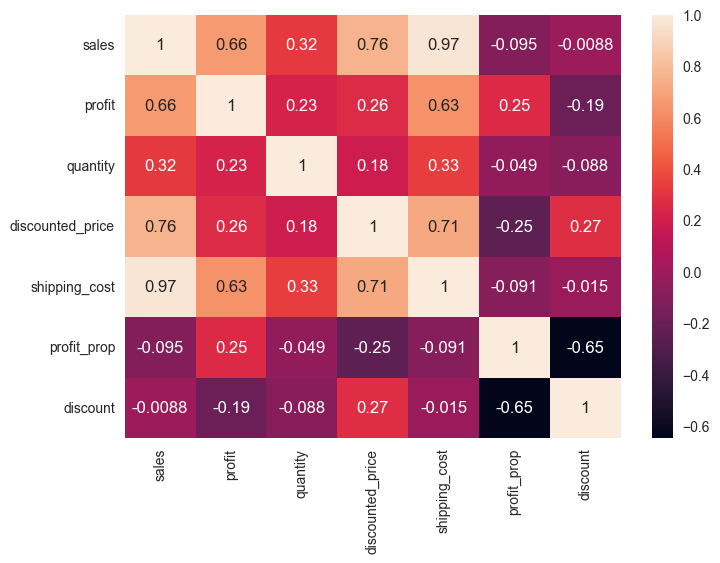

In [ ]:
sns.heatmap(product_sales.corr(numeric_only=True), annot=True)

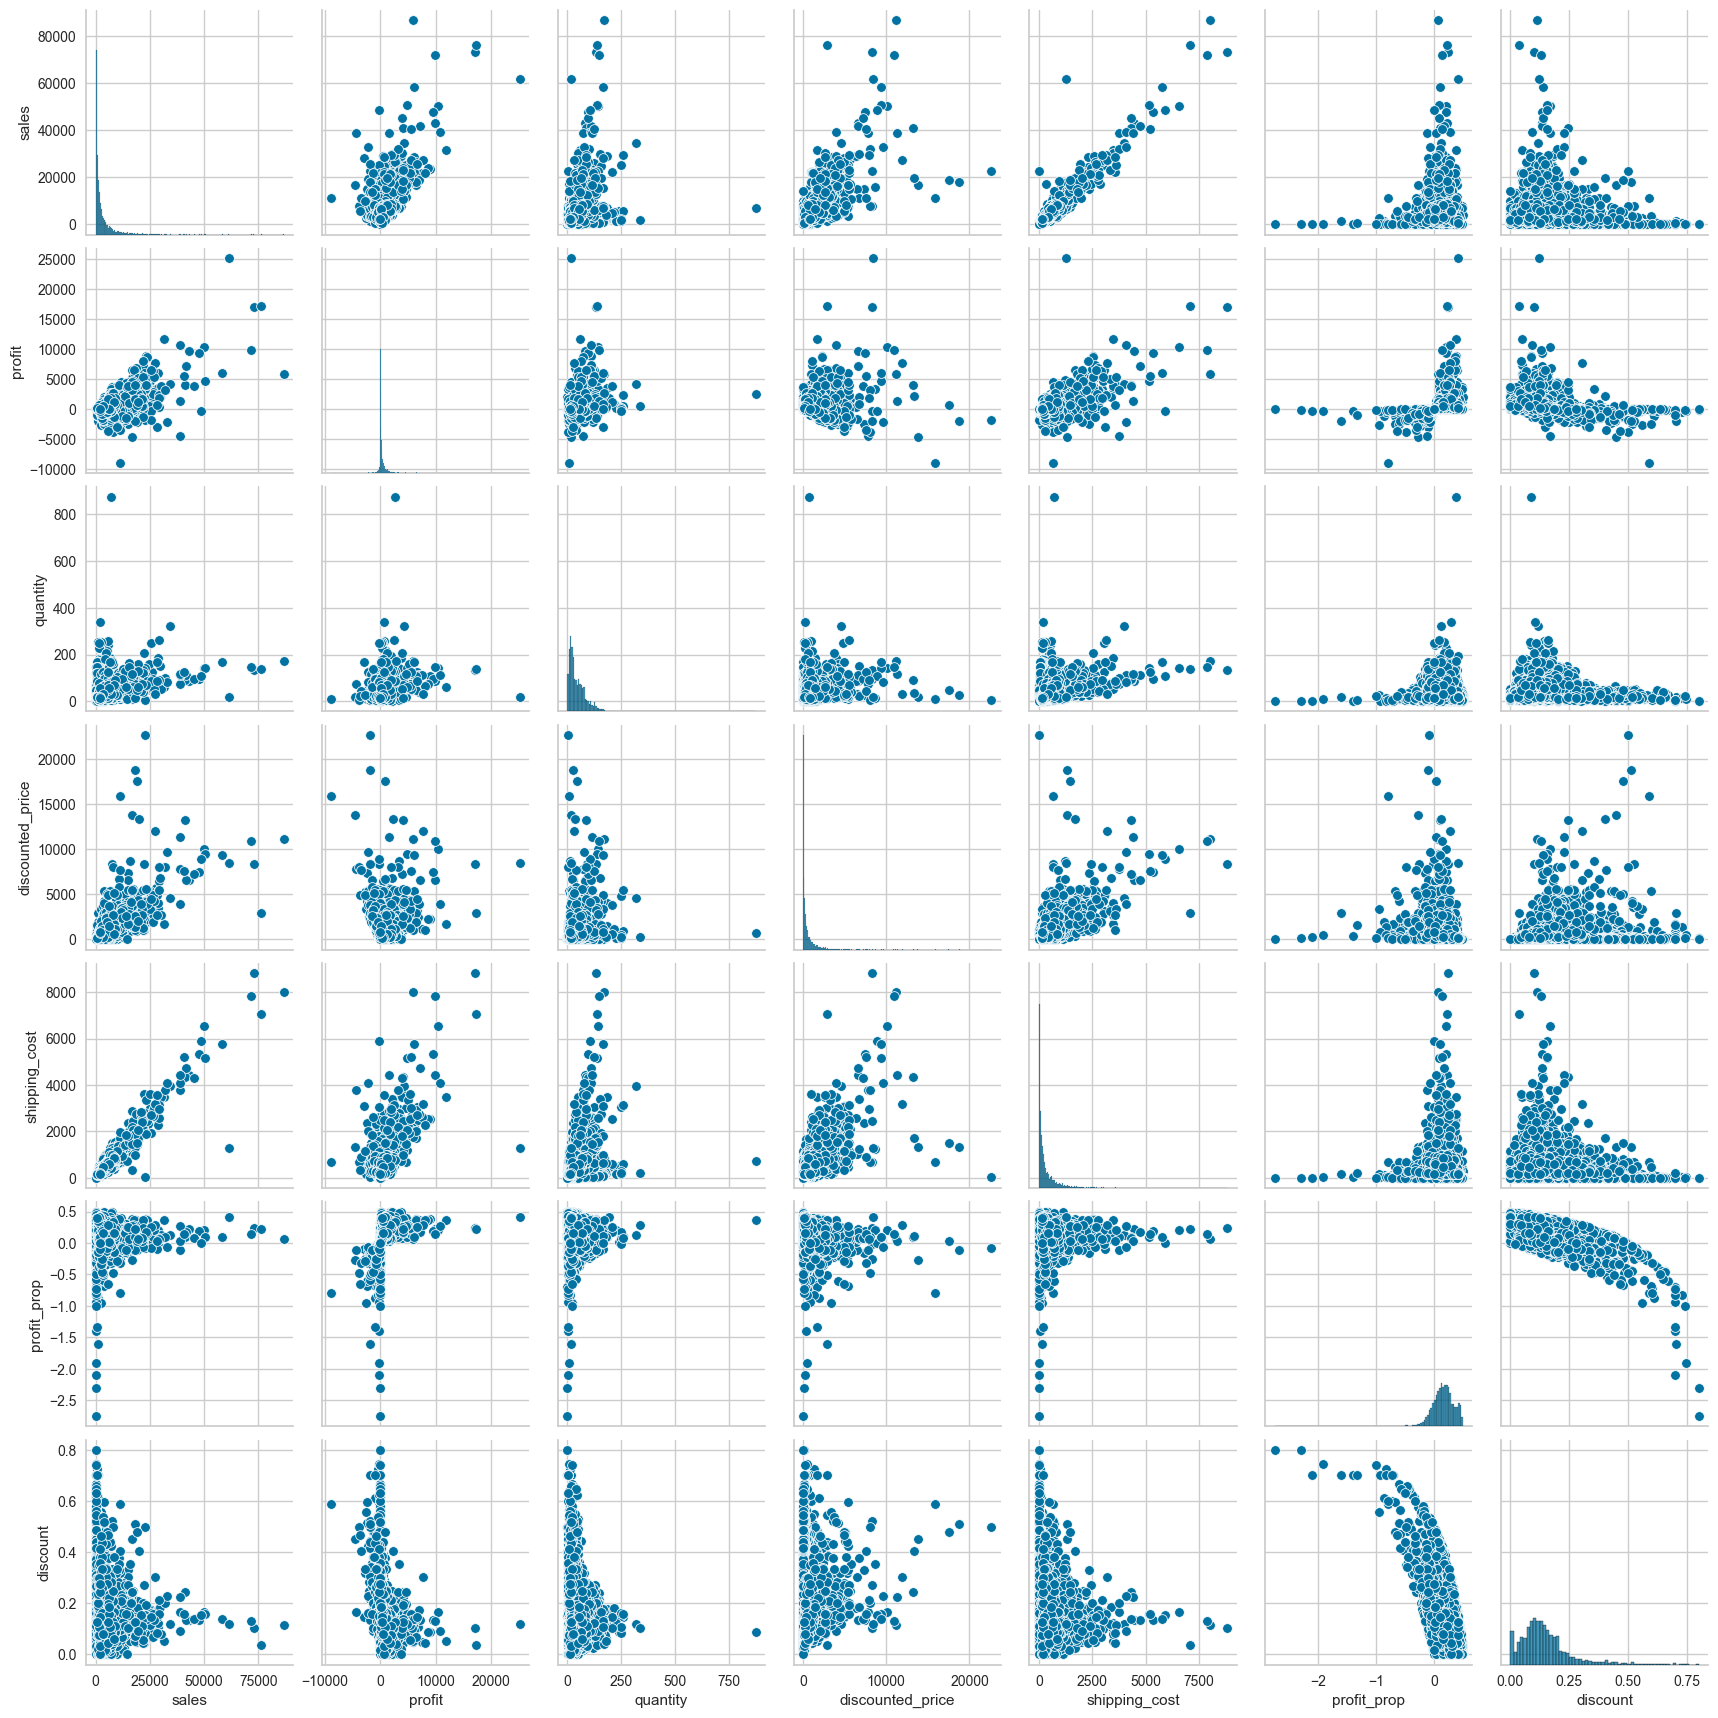

In [ ]:
sns.pairplot(product_sales)

<Axes: xlabel='quantity', ylabel='original_ppu'>

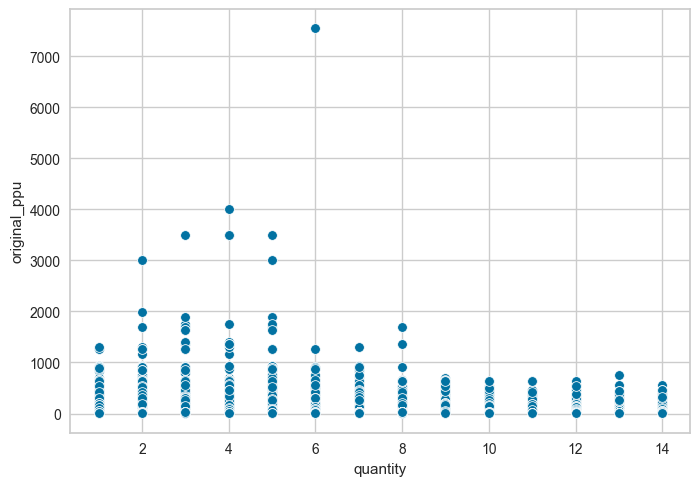

In [ ]:
sns.scatterplot(data=global_superstore[["original_ppu","quantity"]],
                x="quantity",
                y="original_ppu")

Price does not depend on quantity, so we can calculate margins:

In [ ]:
product_sales["original_price"] = product_sales["discounted_price"] + product_sales["sales"]
product_sales["discounted_shipping"] = product_sales["shipping_cost"]/(1-product_sales["discount"]) - product_sales["shipping_cost"]
product_sales["profit_before_discounts"] = product_sales["discounted_shipping"] + product_sales["discounted_price"] + product_sales["profit"]
product_sales["margin_wo_discount"] = product_sales["profit_before_discounts"] / product_sales["original_price"]

<Axes: >

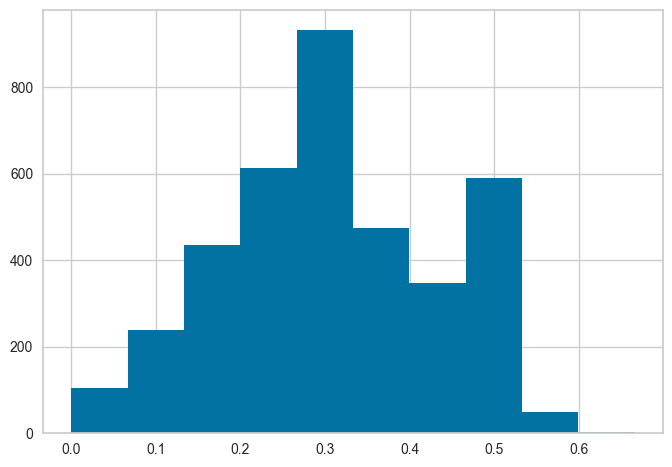

In [ ]:
product_sales["margin_wo_discount"].hist()

### Customer level

Are heavy discounts dependent on good customers?

In [ ]:
customer_sales = (global_superstore
                .groupby("customer_id")[["sales","profit","quantity","discounted_price","shipping_cost"]]
                .agg(
                    sales=("sales","sum"),
                    profit=("profit","sum"),
                    quantity=("quantity","sum"),
                    discounted_price=("discounted_price","sum"),
                    shipping_cost=("shipping_cost","sum")))

customer_sales["profit_prop"] = customer_sales["profit"] / customer_sales["sales"] 
customer_sales["discount"] = customer_sales["discounted_price"] / (customer_sales["discounted_price"] + customer_sales["sales"])

customer_sales.describe().T

count          mean          std          min           25%  \
sales             795.0  15902.518126  5209.813042  3892.227000  12242.608650   
profit            795.0   1845.858228  1544.335187 -6151.558100    984.341310   
quantity          795.0    224.291824    50.569979    79.000000    188.000000   
discounted_price  795.0   2973.570214  1901.298266   246.543000   1781.426330   
shipping_cost     795.0   1701.661245   594.756602   406.040000   1270.655000   
profit_prop       795.0      0.112522     0.084185    -0.458055      0.074263   
discount          795.0      0.154155     0.065723     0.033665      0.109192   

                           50%           75%           max  
sales             15257.533900  18770.796450  40488.070800  
profit             1788.719800   2603.600930   8672.898900  
quantity            222.000000    256.000000    411.000000  
discounted_price   2603.340800   3713.811750  24878.727040  
shipping_cost      1641.800000   2034.210000   4127.570000  
profit_prop           0.119835      0.167039      0.367335  
discount              0.145182      0.184874      0.492058

<Axes: >

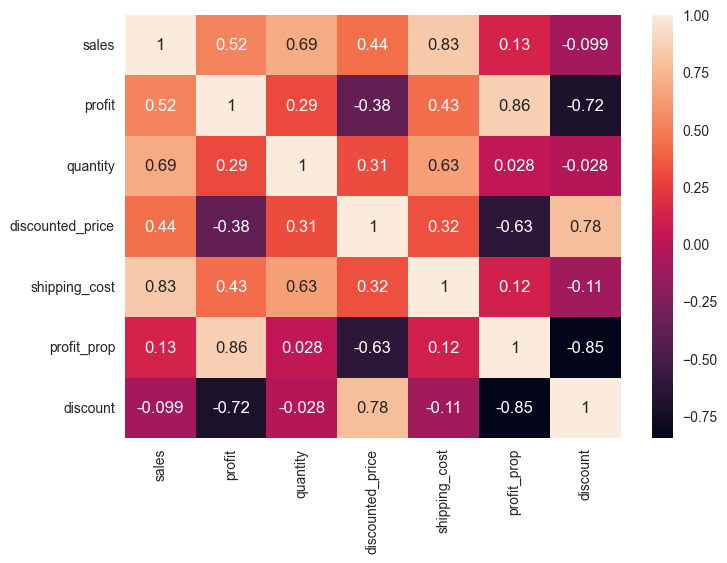

In [ ]:
sns.heatmap(customer_sales.corr(numeric_only=True), annot=True)

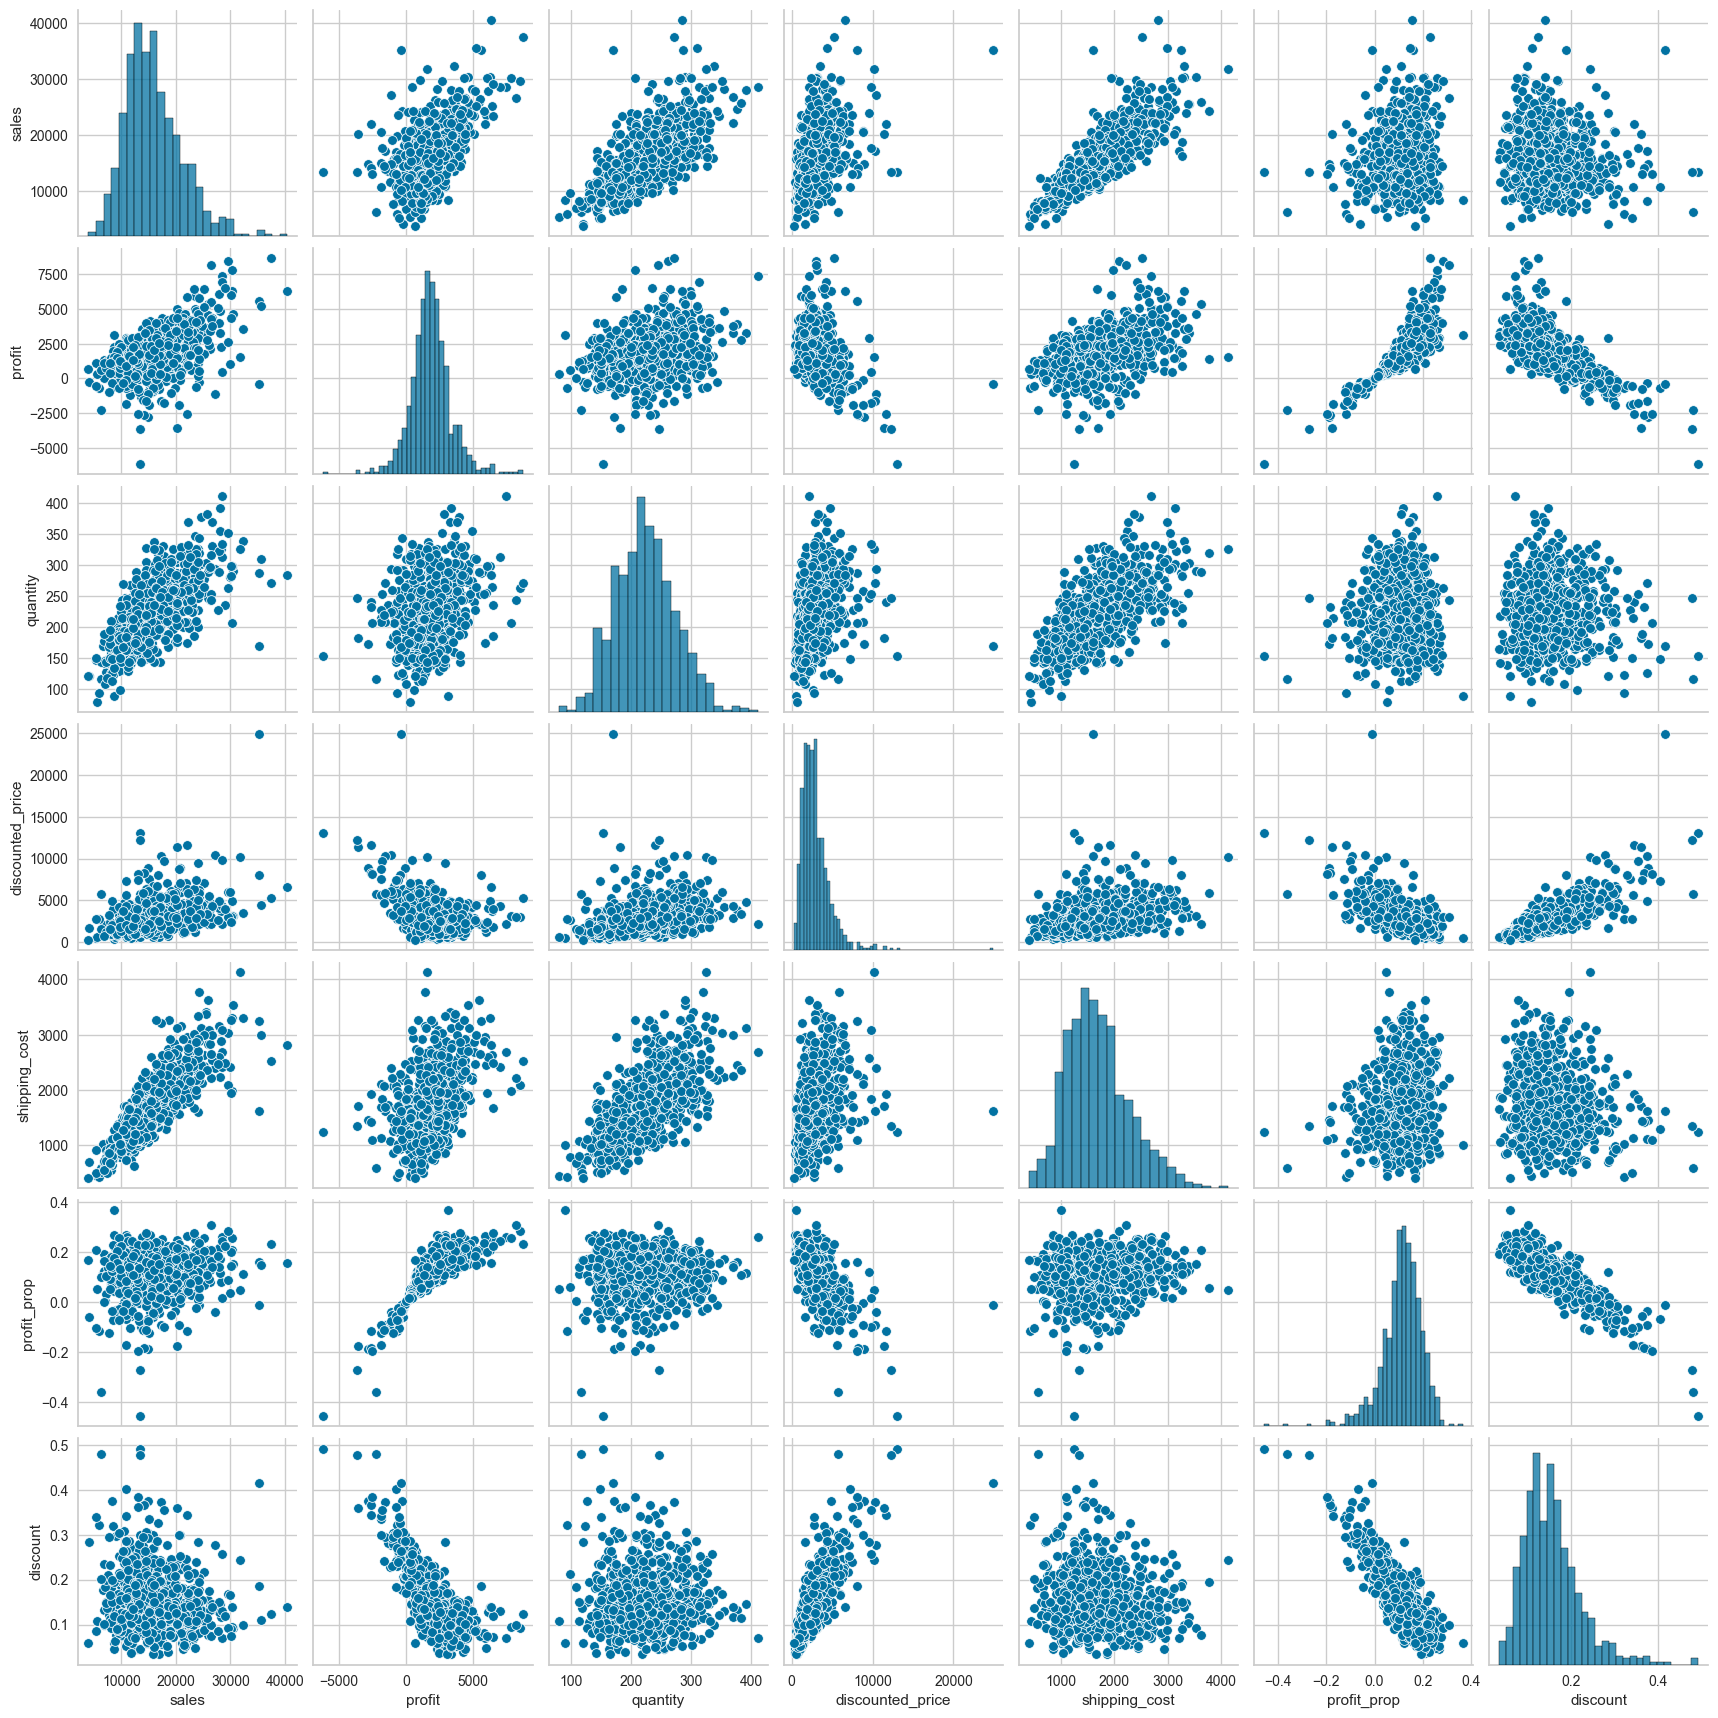

In [ ]:
sns.pairplot(customer_sales)

no_discount  is_discount      prop
customer_id                                    
AA-10315      302.378387   456.029474  0.663068
AA-10375      144.070909   144.521364  0.996883
AA-10480      332.577500   625.981000  0.531290
AA-10645      178.530612   283.412857  0.629931
AB-10015      260.229167   389.099512  0.668798
...                  ...          ...       ...
XP-11865      151.055135   353.786667  0.426967
YC-11895      273.378611   628.472000  0.434989
YS-11880      253.751000   851.567500  0.297981
ZC-11910      351.080625   511.359245  0.686564
ZD-11925      179.916250   433.474091  0.415057

[795 rows x 3 columns]

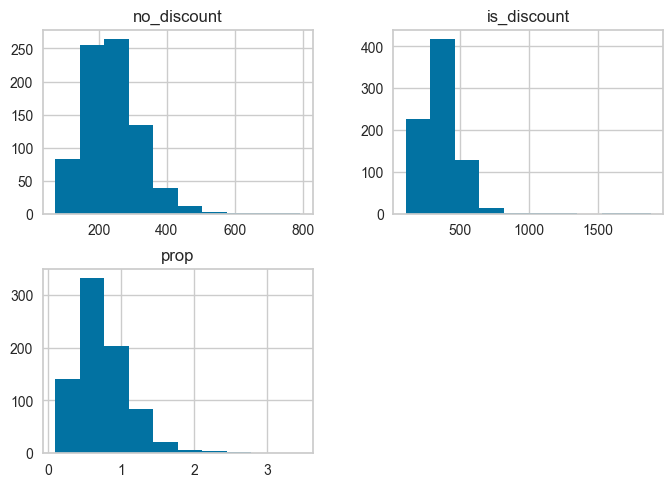

In [ ]:
# agg expense when there's discount or not
mean_expense = global_superstore.groupby(['customer_id', 'is_discount'])['original_price'].mean().unstack()
mean_expense

# rename columns for clarity
mean_expense.columns = ['no_discount', 'is_discount']
mean_expense["prop"] = mean_expense['no_discount'] / mean_expense['is_discount']
mean_expense.hist()
mean_expense

In [ ]:
# variation of total discounted
mean_expense = global_superstore.groupby(['customer_id', 'is_discount'])['original_price'].mean().unstack()
mean_expense

# rename columns for clarity
mean_expense.columns = ['no_discount', 'is_discount']
mean_expense["prop"] = mean_expense['no_discount'] / mean_expense['is_discount']
mean_expense.hist()
mean_expense

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14984\1125460757.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_client = global_superstore.groupby('customer_id').apply(calculate_discount_expense_correlation).reset_index()


array([[<Axes: title={'center': 'elasticidad_descuento'}>]], dtype=object)

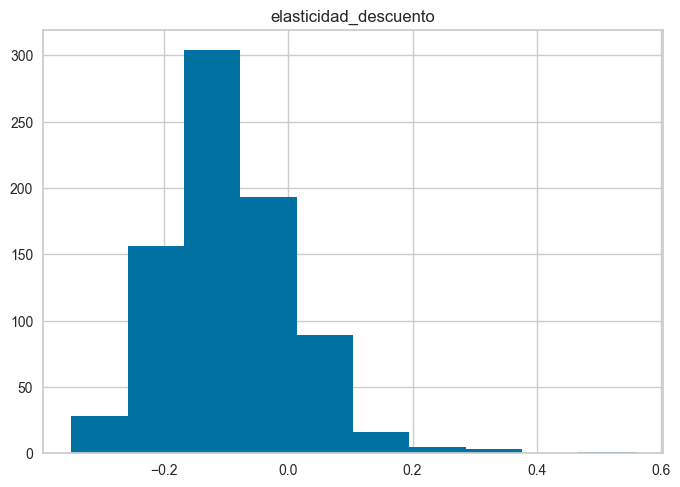

In [ ]:
# function to calculate corr per client
def calculate_discount_expense_correlation(grupo):
    if len(grupo['discount'].unique()) > 1: # if there's variation in discounts
        return grupo['discount'].corr(grupo['sales'], method="pearson")  # return pearson corr
    return 0  # else 0

# Agrupar por cliente y calcular elasticidad
corr_client = global_superstore.groupby('customer_id').apply(calculate_discount_expense_correlation).reset_index()
corr_client.columns = ['customer_id', 'elasticidad_descuento']
corr_client.sort_values(by="elasticidad_descuento",ascending=False).hist()

## 2.2 Temporal analysis

Resumen para mí: Los porcentajes de descuento aplicados de media por cliente no parecen tener relacion con la cantidad de compras que realizan, ni con la facturación que aportan. La hipótesis actual es que los descuentos deben entonces tener algún tipo de patrón temporal de rebajas, con el afán de aumentar las ventas.

Resultado de abajo: **Revisar mejor** No hay un patrón claro entre aumento de ventas conforme aumentan los descuentos en cuanto al análisis temporal se refiere. De hecho, el análisis de correlación indica una correlación negativa entre los descuentos y la facturación. Pudiera ser que los descuentos tuvieran un efecto mitigador y por eso se ve amortiguado de tal manera que no parece haber efecto positivo de los descuentos, pero eso me da la confirmación para saber que los beneficios no dependen directamente de los clientes. 

IMPORTANTE: Tendría entonces que estudiar si los clientes tienen correlación con los descuentos y ver si alguno compra debido a ellos, ya que en ese caso no me conviene tenerlos.

Otro insight: El precio del envío también está descontado.

Falta: Categóricas y ver cómo meto que los customers compren solo cuando hay descuento

Pendiente: análisis semanal

Sales by month of the year

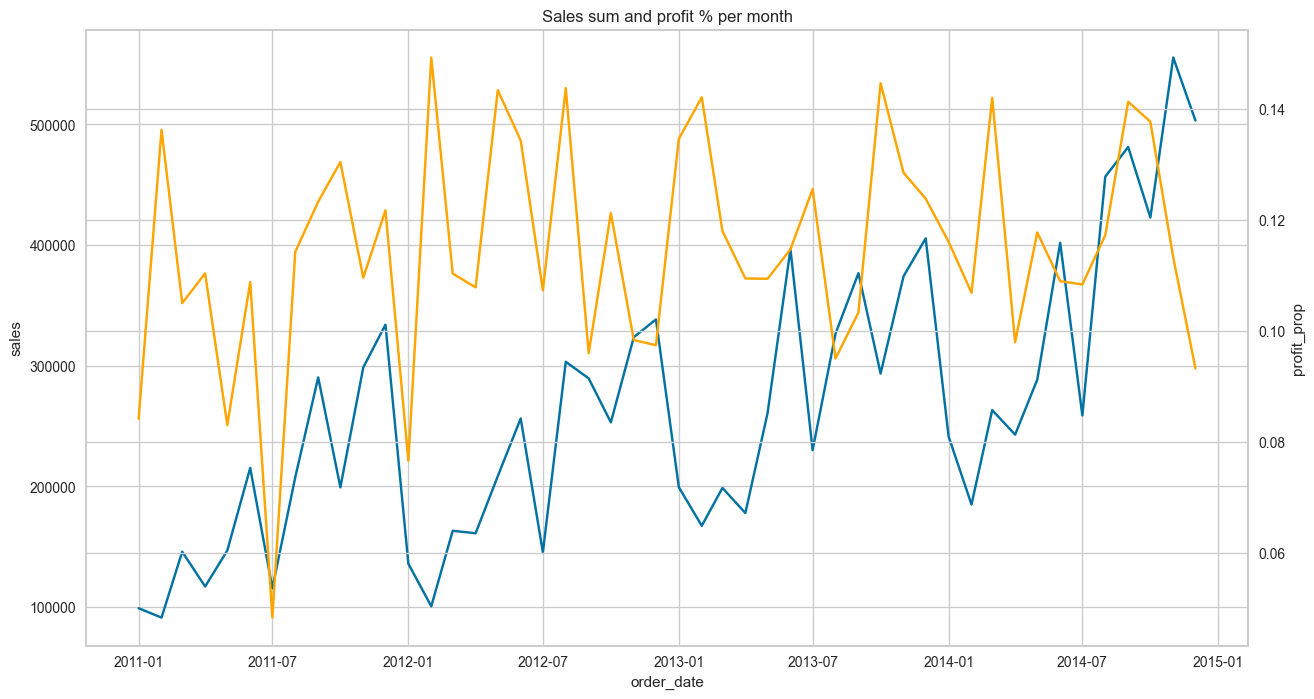

In [ ]:
monthly_sales = global_superstore.set_index("order_date")[["sales","profit"]].resample("MS").sum()
monthly_sales["profit_prop"] = monthly_sales["profit"] / monthly_sales["sales"]


fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()

plt.title("Sales sum and profit % per month")
sns.lineplot(data=monthly_sales,
             x="order_date",
             y="sales",
             ax=ax)

sns.lineplot(data=monthly_sales,
             x="order_date",
             y="profit_prop",
             ax=ax2,
             color="orange")
plt.show()

Monthly discounts

In [ ]:
monthly_discounts = global_superstore.set_index("order_date")[["discounted_price","original_price","profit"]].resample("MS").sum()
monthly_discounts["discount"] = monthly_discounts["discounted_price"] / monthly_discounts["original_price"]
monthly_discounts = monthly_discounts.to_period("M")
monthly_discounts["order_date"] = monthly_discounts.index.astype("str")
monthly_discounts.head()

NameError: name 'global_superstore' is not defined

<Axes: >

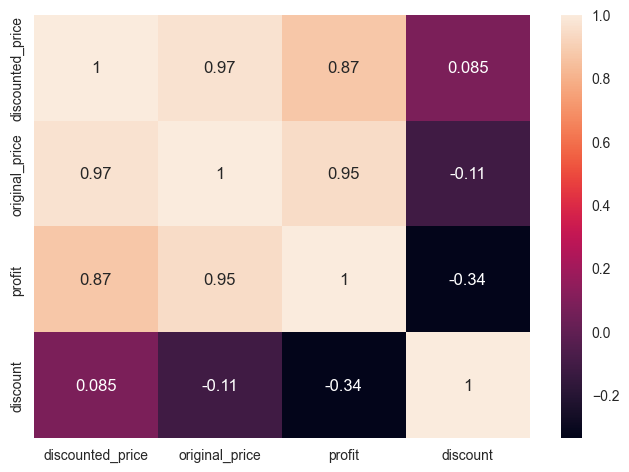

In [ ]:
sns.heatmap(monthly_discounts.corr(numeric_only=True, method="spearman"),annot=True)

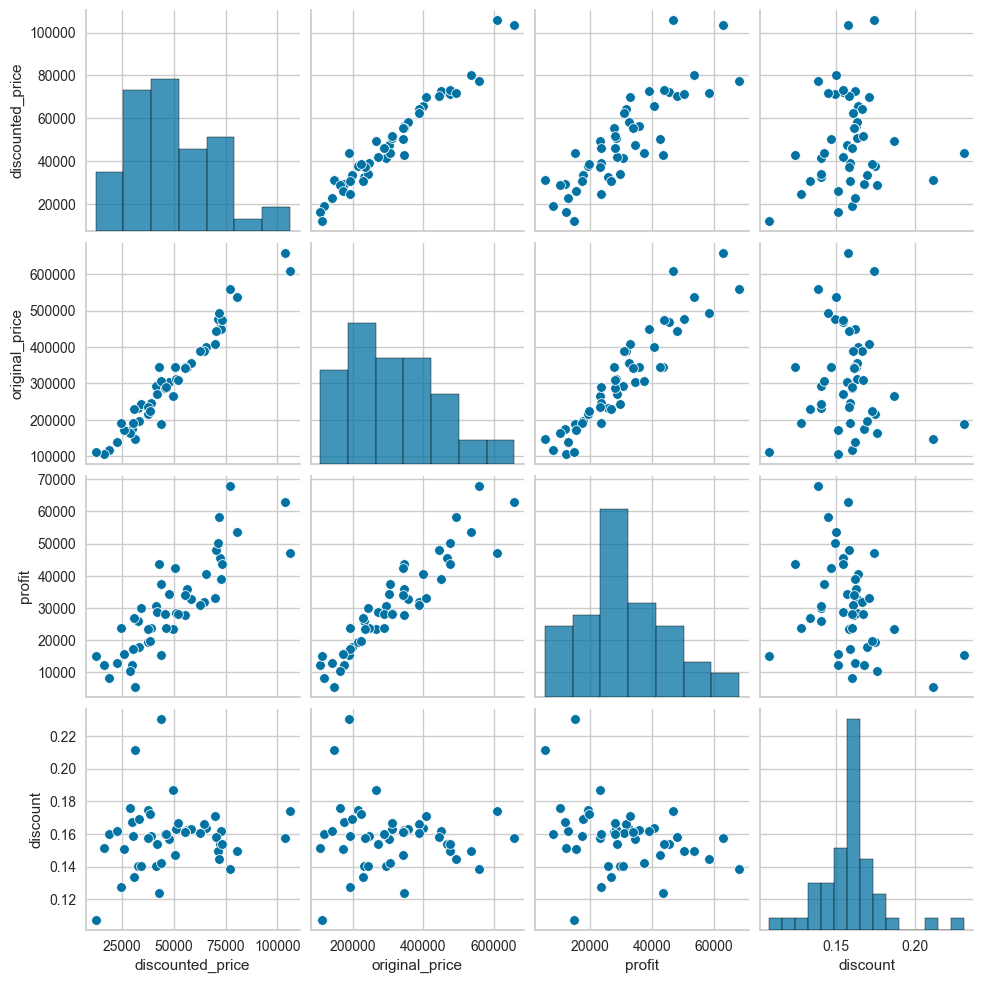

In [ ]:
sns.pairplot(monthly_discounts)

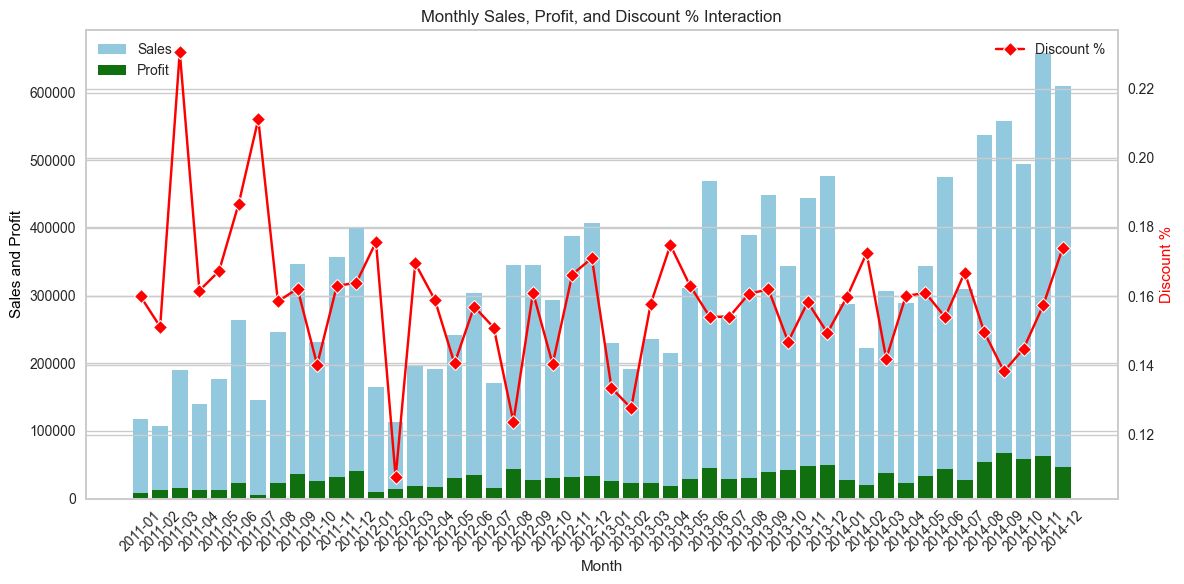

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barplot for original_price (Sales proxy)
sns.barplot(
    data=monthly_discounts,
    x='order_date', 
    y='original_price', 
    ax=ax1, 
    color='skyblue', 
    label='Sales'
)

# Lineplot for Profit on the same axis
sns.barplot(
    data=monthly_discounts,
    x="order_date",
    y="profit",
    ax=ax1,
    color="green",
    label="Profit"
)

# sns.lineplot(
#     data=monthly_discounts,
#     x="order_date",
#     y="profit",
#     ax=ax1,
#     color='green', 
#     marker='o', 
#     label='Profit'
# )

# Secondary axis for Discount
ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_discounts,
    x="order_date",
    y="discount",
    ax=ax2,
    color='red', 
    marker='D', 
    linestyle='-', 
    label='Discount %'
)

# Customizations
ax1.set_ylabel('Sales and Profit', color='black')
ax2.set_ylabel('Discount %', color='red')
ax1.set_xlabel('Month')
ax1.set_title('Monthly Sales, Profit, and Discount % Interaction')

# Rotate x-axis labels for better readability
ax1.set_xticks(range(len(monthly_discounts)))
ax1.set_xticklabels(monthly_discounts['order_date'], rotation=45)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


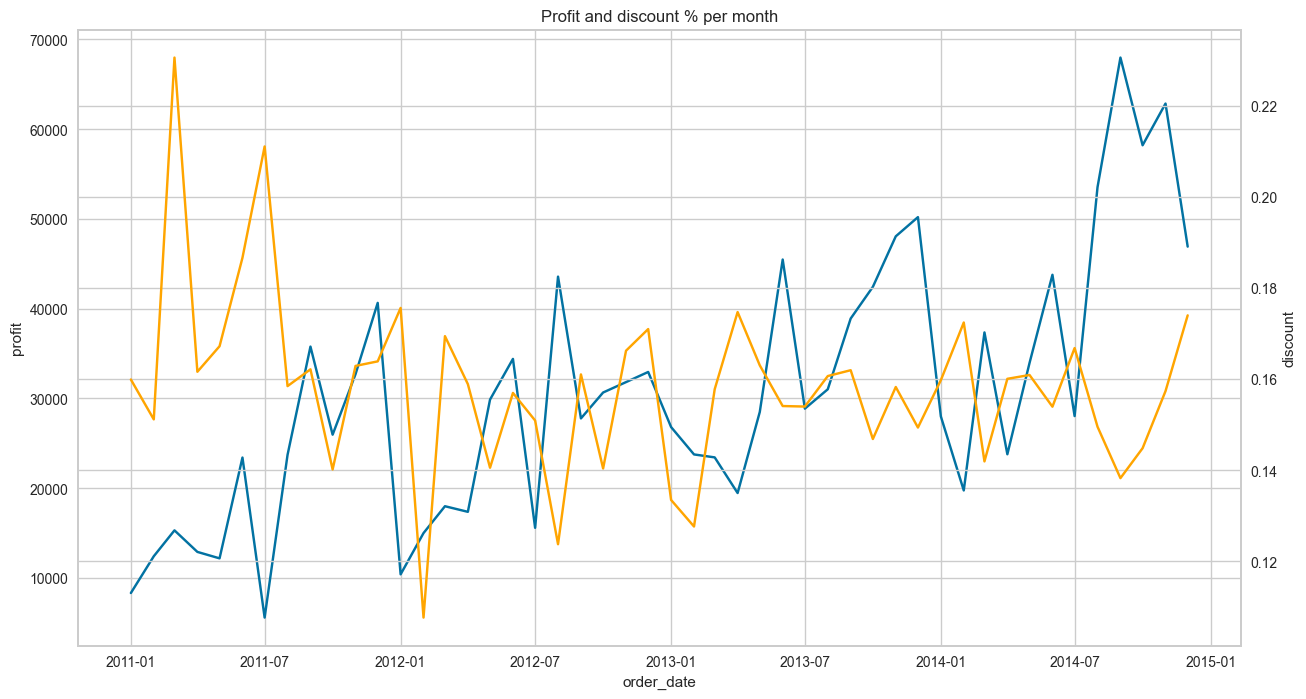

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()

plt.title("Profit and discount % per month")

sns.lineplot(data=monthly_sales,
             x="order_date",
             y="profit",
             ax=ax)

sns.lineplot(data=monthly_discounts,
             x="order_date",
             y="discount",
             ax=ax2,
             color="orange")

plt.show()

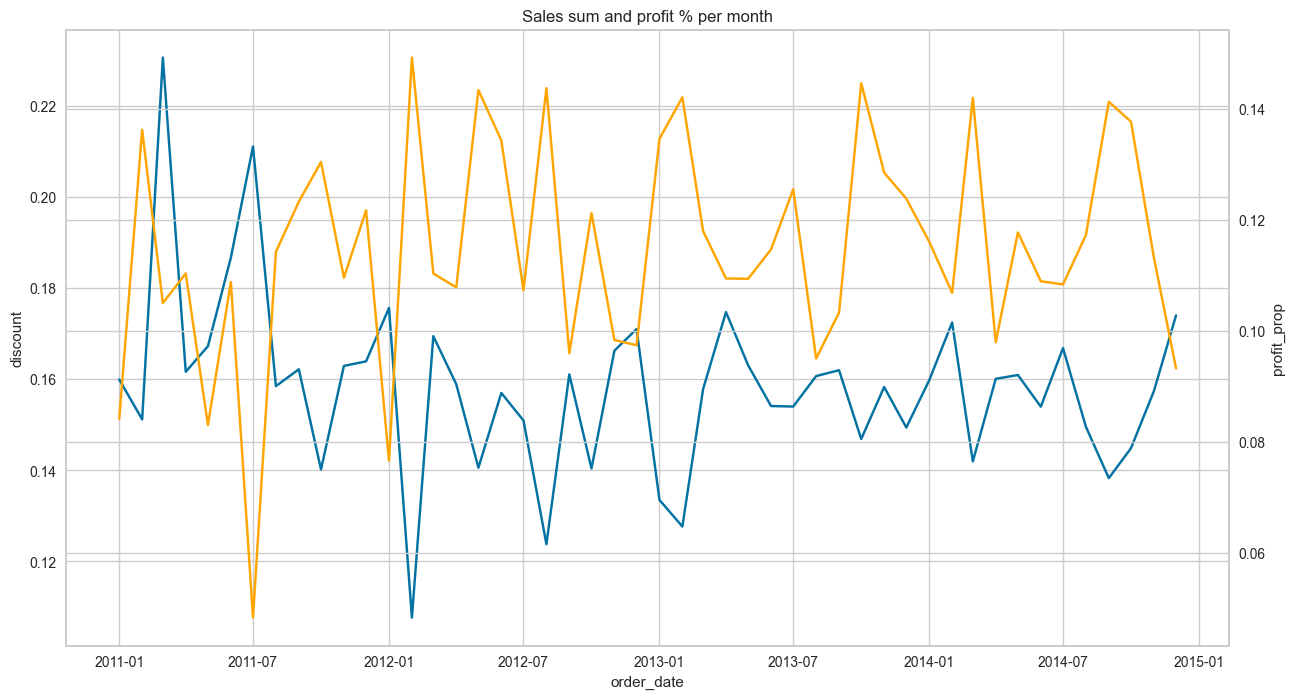

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()

plt.title("Sales sum and profit % per month")
sns.lineplot(data=monthly_discounts,
             x="order_date",
             y="discount",
             ax=ax)

sns.lineplot(data=monthly_sales,
             x="order_date",
             y="profit_prop",
             ax=ax2,
             color="orange")
plt.show()

In [ ]:
global_superstore["order_id"].value_counts()

order_id
CA-2014-100111     14
IN-2012-41261      13
TO-2014-9950       13
IN-2013-42311      13
NI-2014-8880       13
                   ..
ES-2013-1579342     1
MX-2012-134460      1
IN-2013-34366       1
US-2011-152723      1
CA-2012-162544      1
Name: count, Length: 25035, dtype: int64

## 2.2 Univariate data analysis - customer level

To analyze data on the customer level it is necessary to aggregate it by customer. Numerical features are quite straightforward, but categorical pose an additional challenge as they cannot be summed or averaged. Thus let us start by numerical features to then discuss the approach on categorical ones.

In [ ]:
global_superstore.select_dtypes(np.number).head()

sales  discount    profit  shipping_cost
0  2309.650       0.0  762.1845         933.57
1  3709.395       0.1 -288.7650         923.63
2  5175.171       0.1  919.9710         915.49
3  2892.510       0.1  -96.5400         910.16
4  2832.960       0.0  311.5200         903.04

Records are on a product-by-order row level aggregation. Let's calculate the following:
- Sum of sales
- Average sales amount by order
- Total quantity bought
- Average quantity per order
- Average sales per order
- N_orders per month
- N_orders total
- Sum of profit
- Avg profit per order
- Avg profit per quantity
- Average discount (calculate with care)
- Time since first buy (optional)
- Time since last buy (optional)


In [ ]:
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]

In [ ]:
global_superstore

row_id         order_id order_date  ship_date       ship_mode  \
0      32298   CA-2012-124891 2012-07-31 2012-07-31        Same Day   
1      26341    IN-2013-77878 2013-02-05 2013-02-05    Second Class   
2      25330    IN-2013-71249 2013-10-17 2013-10-17     First Class   
3      13524  ES-2013-1579342 2013-01-28 2013-01-28     First Class   
4      47221     SG-2013-4320 2013-11-05 2013-11-05        Same Day   
...      ...              ...        ...        ...             ...   
51285  29002    IN-2014-62366 2014-06-19 2014-06-19        Same Day   
51286  35398   US-2014-102288 2014-06-20 2014-06-20  Standard Class   
51287  40470   US-2013-155768 2013-12-02 2013-12-02        Same Day   
51288   9596   MX-2012-140767 2012-02-18 2012-02-18  Standard Class   
51289   6147   MX-2012-134460 2012-05-22 2012-05-22    Second Class   

      customer_id     customer_name      segment  market product_id  \
0        RH-19495       Rick Hansen     Consumer      US       PR-0   
1        JR-16210     Justin Ritter    Corporate    APAC       PR-1   
2        CR-12730      Craig Reiter     Consumer    APAC       PR-2   
3        KM-16375  Katherine Murray  Home Office      EU       PR-3   
4        RH-19495       Rick Hansen     Consumer  Africa       PR-4   
...           ...               ...          ...     ...        ...   
51285    KE-16420   Katrina Edelman    Corporate    APAC    PR-2266   
51286    ZC-11910  Zuschuss Carroll     Consumer      US    PR-3764   
51287    LB-16795    Laurel Beltran  Home Office      US    PR-3365   
51288    RB-19795        Ross Baird  Home Office   LATAM    PR-2482   
51289    MC-18100     Mick Crebagga     Consumer   LATAM    PR-1589   

              category sub-category  \
0           Technology  Accessories   
1            Furniture       Chairs   
2           Technology       Phones   
3           Technology       Phones   
4           Technology      Copiers   
...                ...          ...   
51285  Office Supplies    Fasteners   
51286  Office Supplies   Appliances   
51287  Office Supplies    Envelopes   
51288  Office Supplies      Binders   
51289  Office Supplies        Paper   

                                            product_name     sales quantity  \
0      Plantronics CS510 - Over-the-Head monaural Wir...  2309.650        7   
1              Novimex Executive Leather Armchair, Black  3709.395        9   
2                      Nokia Smart Phone, with Caller ID  5175.171        9   
3                         Motorola Smart Phone, Cordless  2892.510        5   
4                         Sharp Wireless Fax, High-Speed  2832.960        8   
...                                                  ...       ...      ...   
51285                      Advantus Thumb Tacks, 12 Pack    65.100        5   
51286  Hoover Replacement Belt for Commercial Guardsm...     0.444        1   
51287       #10- 4 1/8" x 9 1/2" Security-Tint Envelopes    22.920        3   
51288                            Acco Index Tab, Economy    13.440        2   
51289            Eaton Computer Printout Paper, 8.5 x 11    61.380        3   

       discount    profit  shipping_cost order_priority  discounted_price  
0           0.0  762.1845         933.57       Critical             0.000  
1           0.1 -288.7650         923.63       Critical           412.155  
2           0.1  919.9710         915.49         Medium           575.019  
3           0.1  -96.5400         910.16         Medium           321.390  
4           0.0  311.5200         903.04       Critical             0.000  
...         ...       ...            ...            ...               ...  
51285       0.0    4.5000           0.01         Medium             0.000  
51286       0.8   -1.1100           0.01         Medium             1.776  
51287       0.0   11.2308           0.01           High             0.000  
51288       0.0    2.4000           0.00         Medium             0.000  
51289       0.0    1.8000           0.00      

In [ ]:
(global_superstore.groupby(["customer_id","order_id"])[["sales","discount","profit","shipping_cost"]]
                                                        .agg(
                                                            sales_sum=("sales","sum"),
                                                            discounted_price_sum=lambda row: row["sales"]/(1-row["discount"]) - row["sales"],
                                                            
                                                                    
                                                        ))

TypeError: <lambda>() missing 1 required positional argument: 'row'


For categoricals, it is necessary to explore how to aggregate:
- Segment
- Order priority
- Category
which will then have to be encoded too.